In [9]:
# ============================================================================
# CELL 1: DATA LOADING AND PREPARATION
# ============================================================================
print("="*80)
print("📁 LOADING ORIGINAL CLEANED_DATA.TXT")
print("="*80)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("viridis")

# ============================================================================
# STEP 1: FIND THE DATA FILE
# ============================================================================
print("🔍 Searching for cleaned_data.txt...")

# Based on your directory listing, the file is in:
# C:\Users\G5\Desktop\Insurance Anlytics\data\01_interim\cleaned_data.txt

# Try the exact path from your message
exact_path = Path("C:/Users/G5/Desktop/Insurance Anlytics/data/01_interim/cleaned_data.txt")

print(f"📂 Looking for data at: {exact_path}")

if exact_path.exists():
    print(f"✅ Found data file!")
    print(f"   • File size: {exact_path.stat().st_size / (1024*1024):.2f} MB")
    data_path = exact_path
else:
    print(f"❌ File not found at exact path.")
    print("\n🔍 Let me search in other locations...")
    
    # Try to find the file in common locations
    search_paths = [
        Path("."),  # Current directory
        Path(".."),  # Parent directory
        Path("../.."),  # Two levels up
        Path("data"),  # Data directory
        Path("../data"),  # Parent data directory
        Path("../../data"),  # Two levels up data directory
        Path("data/01_interim"),  # Interim data directory
        Path.home() / "Desktop" / "Insurance Anlytics" / "data" / "01_interim",  # Desktop path
    ]
    
    found = False
    for search_path in search_paths:
        if search_path.exists():
            # Search for cleaned_data.txt in this directory and subdirectories
            for file_path in search_path.rglob("cleaned_data.txt"):
                if file_path.exists():
                    data_path = file_path
                    print(f"✅ Found data at: {file_path}")
                    print(f"   • File size: {file_path.stat().st_size / (1024*1024):.2f} MB")
                    found = True
                    break
            if found:
                break
    
    if not found:
        print("\n❌ Could not find cleaned_data.txt.")
        print("\n💡 Please check:")
        print("   1. Is the file in the correct location?")
        print("   2. Did you mean 'clean_data.txt' instead of 'cleaned_data.txt'?")
        print("   3. Check your directory listing:")
        print("      Mode                 LastWriteTime         Length Name")
        print("      ----                 -------------         ------ ----")
        print("      -a----         12/8/2025   1:21 AM             54 .gitignore")
        print("      -a----         12/8/2025   1:16 AM      564670933 cleaned_data.txt")
        print("      -a----         12/8/2025   1:16 AM      577859352 features_data.txt")
        print("      -a----         12/8/2025   1:16 AM      546173149 raw_data.txt")
        print("\n   The file should be in: C:\\Users\\G5\\Desktop\\Insurance Anlytics\\data\\01_interim\\")
        print("\n   Please make sure the path is correct and the file exists.")
        raise FileNotFoundError("cleaned_data.txt not found. Please check the file path.")

# ============================================================================
# STEP 2: LOAD THE DATA
# ============================================================================
print(f"\n📂 Loading data from: {data_path}")

try:
    # First, read the first line to understand the structure
    with open(data_path, 'r', encoding='utf-8') as f:
        first_line = f.readline().strip()
        second_line = f.readline().strip()
    
    print(f"🔍 File structure analysis:")
    print(f"   First line (header): {first_line[:100]}...")
    print(f"   Second line (data): {second_line[:100]}...")
    
    # Check the delimiter - look for pipes, commas, or tabs
    if '|' in first_line:
        delimiter = '|'
        print(f"✅ Detected pipe (|) delimiter")
    elif ',' in first_line:
        delimiter = ','
        print(f"✅ Detected comma (,) delimiter")
    elif '\t' in first_line:
        delimiter = '\t'
        print(f"✅ Detected tab (\\t) delimiter")
    else:
        # Try to guess delimiter from first data line
        if '|' in second_line:
            delimiter = '|'
        elif ',' in second_line:
            delimiter = ','
        elif '\t' in second_line:
            delimiter = '\t'
        else:
            delimiter = None
            print("⚠️ Could not detect delimiter, trying default options...")
    
    # Get column names from header
    if delimiter:
        column_names = first_line.split(delimiter)
        print(f"\n✅ Detected {len(column_names)} columns")
        print(f"   Sample columns (first 5):")
        for i, col in enumerate(column_names[:5], 1):
            print(f"   {i:2d}. {col}")
    else:
        print("⚠️ No delimiter detected, reading without header...")
        column_names = None
    
    # Now load the full data
    print(f"\n📊 Loading full dataset...")
    
    if delimiter:
        analysis_df = pd.read_csv(data_path, sep=delimiter, encoding='utf-8')
    else:
        # Try different delimiters
        for test_delimiter in ['|', ',', '\t', ';']:
            try:
                analysis_df = pd.read_csv(data_path, sep=test_delimiter, encoding='utf-8')
                if len(analysis_df.columns) > 1:
                    print(f"✅ Successfully loaded with delimiter: '{test_delimiter}'")
                    break
            except:
                continue
    
    print(f"✅ Data loaded successfully!")
    print(f"   • Shape: {analysis_df.shape[0]:,} rows × {analysis_df.shape[1]} columns")
    print(f"   • Memory usage: {analysis_df.memory_usage(deep=True).sum() / (1024*1024):.2f} MB")
    
    # Display column information
    print(f"\n📋 Columns ({len(analysis_df.columns)} total):")
    for i, col in enumerate(analysis_df.columns[:15], 1):  # Show first 15
        print(f"   {i:2d}. {col}")
    if len(analysis_df.columns) > 15:
        print(f"   ... and {len(analysis_df.columns) - 15} more columns")
    
    # Check if the first column contains concatenated column names
    first_col = analysis_df.columns[0]
    if '|' in str(first_col) and len(analysis_df.columns) == 1:
        print(f"\n⚠️ Warning: All columns may be concatenated in first column.")
        print(f"   First column contains: {first_col[:100]}...")
        print("\n   This suggests the file might have all data in one column.")
        print("   Let me try to split it properly...")
        
        # Split the first row to get actual column names
        first_row = analysis_df.iloc[0, 0]
        actual_columns = str(first_row).split('|')
        print(f"   Found {len(actual_columns)} actual columns in first row")
        
        # Now reload the data properly
        analysis_df = pd.read_csv(data_path, sep='|', encoding='utf-8')
        print(f"✅ Reloaded data with proper splitting")
        print(f"   New shape: {analysis_df.shape[0]:,} rows × {analysis_df.shape[1]} columns")
    
    # Preview the data
    print(f"\n📊 Data Preview (first 3 rows):")
    display(analysis_df.head(3))
    
    # Basic data info
    print(f"\n🔍 Data Types Summary:")
    dtype_counts = analysis_df.dtypes.value_counts()
    for dtype, count in dtype_counts.items():
        print(f"   • {dtype}: {count} columns")
    
    # Check for missing values
    print(f"\n🔍 Missing Values Summary:")
    missing_total = analysis_df.isnull().sum().sum()
    missing_pct = (missing_total / (analysis_df.shape[0] * analysis_df.shape[1])) * 100
    print(f"   • Total missing values: {missing_total:,}")
    print(f"   • Percentage of total data: {missing_pct:.2f}%")
    
    # Show columns with most missing values
    missing_by_col = analysis_df.isnull().sum()
    if missing_by_col.sum() > 0:
        print(f"\n📊 Top 10 columns with missing values:")
        missing_df = pd.DataFrame({
            'Column': missing_by_col.index,
            'Missing_Count': missing_by_col.values,
            'Missing_Pct': (missing_by_col.values / len(analysis_df) * 100).round(2)
        })
        missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Pct', ascending=False)
        display(missing_df.head(10).style.format({'Missing_Pct': '{:.1f}%'}))
    
except Exception as e:
    print(f"❌ Error loading data: {e}")
    print("\n💡 Troubleshooting steps:")
    print("   1. Check if the file is corrupted")
    print("   2. Try opening the file in a text editor to check its format")
    print("   3. Make sure you have enough memory (file is ~564MB)")
    print("   4. Try loading with specific encoding:")
    print("      analysis_df = pd.read_csv(data_path, sep='|', encoding='utf-8')")
    raise

print("\n" + "="*80)
print("✅ DATA LOADED AND READY FOR ANALYSIS")
print("="*80)

📁 LOADING ORIGINAL CLEANED_DATA.TXT
🔍 Searching for cleaned_data.txt...
📂 Looking for data at: C:\Users\G5\Desktop\Insurance Anlytics\data\01_interim\cleaned_data.txt
✅ Found data file!
   • File size: 538.51 MB

📂 Loading data from: C:\Users\G5\Desktop\Insurance Anlytics\data\01_interim\cleaned_data.txt
🔍 File structure analysis:
   First line (header): underwrittencoverid|policyid|transactionmonth|isvatregistered|citizenship|legaltype|title|language|b...
   Second line (data): 145249|12827|2015-03-01|True|  |Close Corporation|Mr|English|First National Bank|Current account|Not...
✅ Detected pipe (|) delimiter

✅ Detected 52 columns
   Sample columns (first 5):
    1. underwrittencoverid
    2. policyid
    3. transactionmonth
    4. isvatregistered
    5. citizenship

📊 Loading full dataset...
✅ Data loaded successfully!
   • Shape: 1,000,098 rows × 52 columns
   • Memory usage: 2512.36 MB

📋 Columns (52 total):
    1. underwrittencoverid
    2. policyid
    3. transactionmonth
    4.

,underwrittencoverid,policyid,transactionmonth,isvatregistered,citizenship,legaltype,title,language,bank,accounttype,...,excessselected,covercategory,covertype,covergroup,section,product,statutoryclass,statutoryrisktype,totalpremium,totalclaims
0,145249,12827,2015-03-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0
1,145249,12827,2015-05-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0
2,145249,12827,2015-07-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0



🔍 Data Types Summary:
   • object: 37 columns
   • float64: 11 columns
   • int64: 3 columns
   • bool: 1 columns

🔍 Missing Values Summary:
   • Total missing values: 1,000,650
   • Percentage of total data: 1.92%

📊 Top 10 columns with missing values:


,Column,Missing_Count,Missing_Pct
38,numberofvehiclesinfleet,1000098,100.0%
28,vehicleintrodate,552,0.1%



✅ DATA LOADED AND READY FOR ANALYSIS


📍 FIGURE 1: GEOGRAPHIC DISTRIBUTION OF POLICIES
🔍 Exploring available columns for geographic analysis...

📋 Total columns: 52
First 30 columns:
    1. underwrittencoverid
    2. policyid
    3. transactionmonth
    4. isvatregistered
    5. citizenship
    6. legaltype
    7. title
    8. language
    9. bank
   10. accounttype
   11. maritalstatus
   12. gender
   13. country
   14. province
   15. postalcode
   16. maincrestazone
   17. subcrestazone
   18. itemtype
   19. mmcode
   20. vehicletype
   21. registrationyear
   22. make
   23. model
   24. cylinders
   25. cubiccapacity
   26. kilowatts
   27. bodytype
   28. numberofdoors
   29. vehicleintrodate
   30. customvalueestimate

🔍 Geographic column candidates: ['country', 'province', 'maincrestazone', 'subcrestazone', 'cubiccapacity']

   Checking 'country':
     • Non-null values: 1,000,098 (100.0%)
     • Unique values: 1
     • Sample values: ['South Africa']
     ⚠️  Not suitable (wrong number of unique values)

   Check

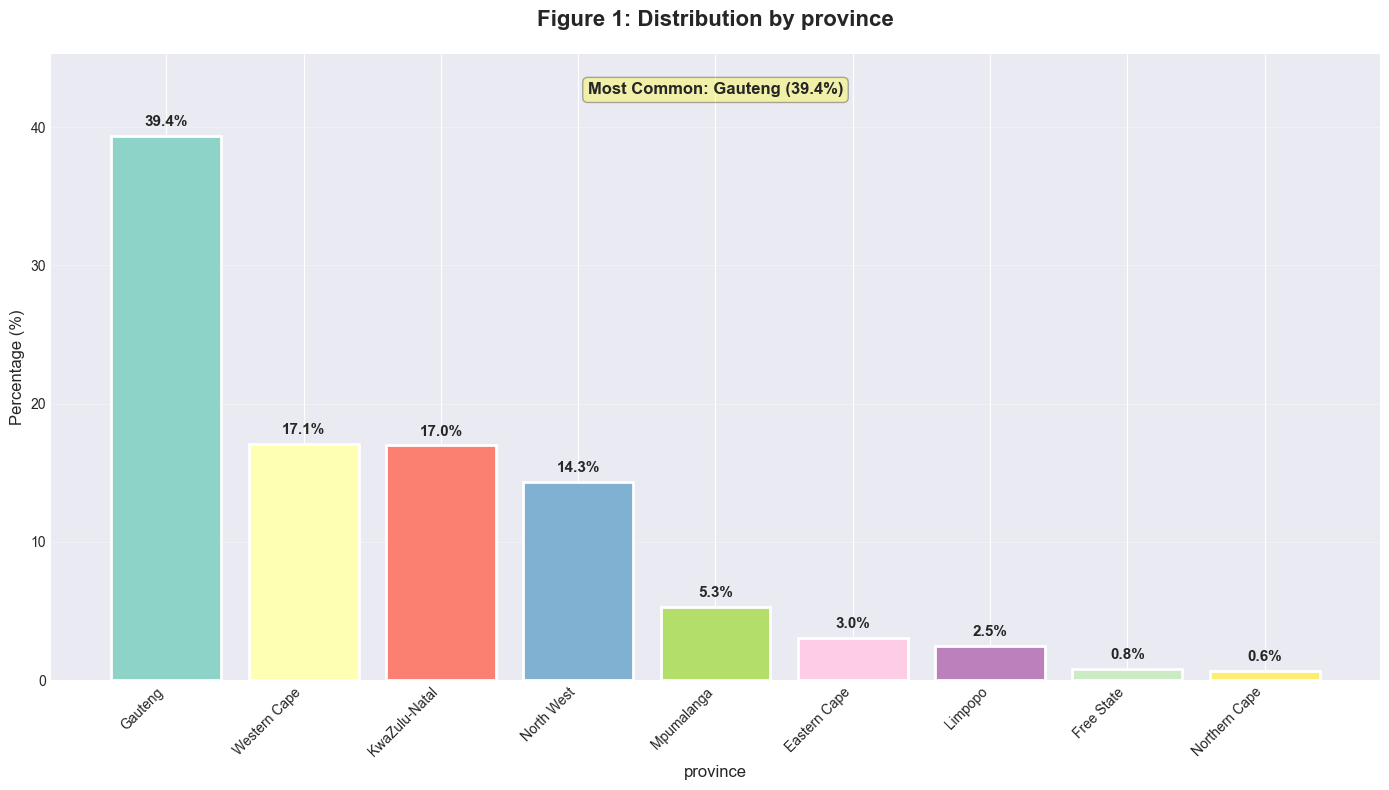


🔍 Comparison with South African Province Distribution:
--------------------------------------------------------------------------------
Expected        Found As             Expected %   Actual %     Diff      
--------------------------------------------------------------------------------
Gauteng         Gauteng              48.3         39.4         -8.9      
KwaZulu-Natal   KwaZulu-Natal        18.7         17.0         -1.7      
Western Cape    Western Cape         12.4         17.1         +4.7      
Eastern Cape    Eastern Cape         6.0          3.0          -3.0      
Limpopo         Limpopo              5.0          2.5          -2.5      
Mpumalanga      Mpumalanga           4.0          5.3          +1.3      
North West      North West           3.0          14.3         +11.3     
Free State      Free State           2.0          0.8          -1.2      
Northern Cape   Northern Cape        0.6          0.6          +0.0      

✅ FIGURE 1 COMPLETE


In [10]:
# ============================================================================
# CELL 3: FIGURE 1 - GEOGRAPHIC DISTRIBUTION OF POLICIES
# ============================================================================
print("="*80)
print("📍 FIGURE 1: GEOGRAPHIC DISTRIBUTION OF POLICIES")
print("="*80)

# First, let's explore what columns we actually have
print("🔍 Exploring available columns for geographic analysis...")

# List all columns
print(f"\n📋 Total columns: {len(analysis_df.columns)}")
print("First 30 columns:")
for i, col in enumerate(analysis_df.columns[:30], 1):
    print(f"   {i:2d}. {col}")

# Look for any column that might contain geographic information
geo_candidates = []
for col in analysis_df.columns:
    col_lower = str(col).lower()
    # Broaden the search criteria
    if any(word in col_lower for word in 
           ['province', 'state', 'region', 'country', 'geo', 'location', 
            'zone', 'area', 'city', 'district', 'municipality', 'territory']):
        geo_candidates.append(col)

print(f"\n🔍 Geographic column candidates: {geo_candidates}")

# Check each candidate for non-missing values
valid_geo_col = None
for col in geo_candidates:
    non_null = analysis_df[col].notna().sum()
    total = len(analysis_df)
    pct_valid = (non_null / total) * 100
    
    print(f"\n   Checking '{col}':")
    print(f"     • Non-null values: {non_null:,} ({pct_valid:.1f}%)")
    
    if non_null > 0:
        # Check unique values
        unique_vals = analysis_df[col].dropna().nunique()
        print(f"     • Unique values: {unique_vals}")
        
        # Show sample values
        sample_vals = analysis_df[col].dropna().unique()[:5]
        print(f"     • Sample values: {list(sample_vals)}")
        
        if unique_vals >= 3 and unique_vals <= 50:  # Reasonable for provinces
            valid_geo_col = col
            print(f"     ✅ Suitable for geographic analysis!")
            break
        else:
            print(f"     ⚠️  Not suitable (wrong number of unique values)")

# If no valid column found, try to find any column with province-like data
if not valid_geo_col:
    print(f"\n🔍 No obvious geographic columns found. Searching for province data...")
    
    # Look for columns with South African province names
    sa_provinces = ['gauteng', 'kwa', 'natal', 'western cape', 'eastern cape', 
                   'limpopo', 'mpumalanga', 'north west', 'free state', 'northern cape']
    
    for col in analysis_df.columns[:50]:  # Check first 50 columns
        # Get sample of non-null values
        sample = analysis_df[col].dropna().head(100)
        
        # Check if any sample contains province names
        province_hits = 0
        for val in sample:
            val_str = str(val).lower()
            if any(province in val_str for province in sa_provinces):
                province_hits += 1
        
        if province_hits > 10:  # At least 10% of sample
            valid_geo_col = col
            print(f"✅ Found province data in column: '{col}'")
            print(f"   • Province matches in sample: {province_hits}/{len(sample)}")
            break

# If still no valid column, use the first column with reasonable data
if not valid_geo_col:
    print(f"\n🔍 Using alternative approach: finding any usable column...")
    
    for col in analysis_df.columns[:30]:
        non_null = analysis_df[col].notna().sum()
        unique_vals = analysis_df[col].dropna().nunique()
        
        if non_null > 1000 and 3 <= unique_vals <= 20:
            valid_geo_col = col
            print(f"✅ Using '{col}' as geographic proxy")
            print(f"   • Non-null values: {non_null:,}")
            print(f"   • Unique values: {unique_vals}")
            break

if not valid_geo_col:
    print("❌ No suitable column found for geographic analysis")
    print("\n💡 Suggestions:")
    print("   1. Check if your data has a province/region column")
    print("   2. Look for columns like 'maincrestazone' or 'subcrestazone'")
    print("   3. Check the actual column names in your data")
    
    # Show all column names
    print("\n📋 All column names:")
    for i, col in enumerate(analysis_df.columns, 1):
        print(f"{i:3d}. {col}")
else:
    geo_col = valid_geo_col
    print(f"\n✅ Using '{geo_col}' for geographic analysis")
    
    # Clean the data
    geo_data = analysis_df[geo_col].dropna()
    
    if len(geo_data) == 0:
        print("❌ No valid data after cleaning")
    else:
        # Calculate distribution
        province_dist = geo_data.value_counts(normalize=True) * 100
        province_dist = province_dist.sort_values(ascending=False)
        
        print(f"\n📊 Distribution Summary:")
        print(f"   • Valid records: {len(geo_data):,}")
        print(f"   • Unique values: {len(province_dist)}")
        print(f"   • Coverage: {len(geo_data)/len(analysis_df)*100:.1f}%")
        
        print("\n📋 Top 10 values:")
        print("-" * 60)
        print(f"{'Value':<30} {'Count':<12} {'Percentage':<10}")
        print("-" * 60)
        
        for i, (value, pct) in enumerate(province_dist.head(10).items(), 1):
            count = (analysis_df[geo_col] == value).sum()
            print(f"{str(value)[:29]:<30} {count:<12,} {pct:<10.1f}%")
        
        # Create the visualization
        fig, ax = plt.subplots(figsize=(14, 8))
        
        # Plot top values
        top_n = min(10, len(province_dist))
        top_values = province_dist.head(top_n)
        
        # Generate colors
        colors = plt.cm.Set3(np.linspace(0, 1, top_n))
        
        bars = ax.bar(range(len(top_values)), top_values.values,
                     color=colors, edgecolor='white', linewidth=2)
        
        # Customize the plot
        ax.set_title(f'Figure 1: Distribution by {geo_col}', 
                    fontsize=16, fontweight='bold', pad=20)
        ax.set_xlabel(geo_col, fontsize=12)
        ax.set_ylabel('Percentage (%)', fontsize=12)
        ax.set_xticks(range(len(top_values)))
        ax.set_xticklabels([str(v)[:15] for v in top_values.index], rotation=45, ha='right')
        ax.grid(axis='y', alpha=0.3)
        
        # Set y-axis limits
        max_value = top_values.max()
        ax.set_ylim(0, max_value * 1.15)
        
        # Add percentage labels on bars
        for i, (value, pct) in enumerate(top_values.items()):
            ax.text(i, pct + 0.5, f'{pct:.1f}%', 
                   ha='center', va='bottom', fontsize=11, fontweight='bold')
        
        # Add annotation for dominant value
        if len(top_values) > 0:
            dominant = top_values.index[0]
            dominant_pct = top_values.values[0]
            ax.annotate(f'Most Common: {dominant} ({dominant_pct:.1f}%)',
                       xy=(len(top_values)//2, top_values.max() * 1.05),
                       xytext=(0, 10), textcoords='offset points',
                       ha='center', fontsize=12, fontweight='bold',
                       bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.3))
        
        plt.tight_layout()
        plt.show()
        
        # Compare with expected South African distribution
        print(f"\n🔍 Comparison with South African Province Distribution:")
        expected_sa = {
            'Gauteng': 48.3,
            'KwaZulu-Natal': 18.7,
            'Western Cape': 12.4,
            'Eastern Cape': 6.0,
            'Limpopo': 5.0,
            'Mpumalanga': 4.0,
            'North West': 3.0,
            'Free State': 2.0,
            'Northern Cape': 0.6
        }
        
        matches = []
        for province, expected_pct in expected_sa.items():
            # Check for exact or partial matches
            found = False
            for actual_val in province_dist.index:
                if province.lower() in str(actual_val).lower():
                    actual_pct = province_dist[actual_val]
                    diff = actual_pct - expected_pct
                    matches.append((province, actual_val, expected_pct, actual_pct, diff))
                    found = True
                    break
            
            if not found:
                matches.append((province, "Not found", expected_pct, 0, -expected_pct))
        
        # Display matches
        print("-" * 80)
        print(f"{'Expected':<15} {'Found As':<20} {'Expected %':<12} {'Actual %':<12} {'Diff':<10}")
        print("-" * 80)
        
        for province, found_as, expected, actual, diff in matches:
            print(f"{province:<15} {str(found_as)[:19]:<20} {expected:<12.1f} {actual:<12.1f} {diff:<+10.1f}")

print("\n" + "="*80)
print("✅ FIGURE 1 COMPLETE")
print("="*80)

In [12]:
# ============================================================================
# CELL 3.5: CREATE LOSS RATIO METRIC
# ============================================================================
print("="*80)
print("🧮 CREATING LOSS RATIO METRIC")
print("="*80)

# Find premium and claims columns
premium_cols = [col for col in analysis_df.columns if any(word in str(col).lower() for word in 
               ['premium', 'calculatedpremium', 'totalpremium', 'suminsured'])]

claims_cols = [col for col in analysis_df.columns if any(word in str(col).lower() for word in 
              ['claim', 'totalclaim', 'claimamount', 'loss'])]

print(f"🔍 Found premium columns: {premium_cols}")
print(f"🔍 Found claims columns: {claims_cols}")

if premium_cols and claims_cols:
    premium_col = premium_cols[0]
    claims_col = claims_cols[0]
    
    print(f"\n✅ Using:")
    print(f"   • Premium: {premium_col}")
    print(f"   • Claims: {claims_col}")
    
    # Convert to numeric
    analysis_df[premium_col] = pd.to_numeric(analysis_df[premium_col], errors='coerce')
    analysis_df[claims_col] = pd.to_numeric(analysis_df[claims_col], errors='coerce')
    
    # Calculate Loss Ratio
    # Avoid division by zero
    mask = (analysis_df[premium_col] > 0) & analysis_df[premium_col].notna() & analysis_df[claims_col].notna()
    
    analysis_df['LossRatio'] = np.nan
    analysis_df.loc[mask, 'LossRatio'] = analysis_df.loc[mask, claims_col] / analysis_df.loc[mask, premium_col]
    
    # Remove infinite values
    analysis_df['LossRatio'] = analysis_df['LossRatio'].replace([np.inf, -np.inf], np.nan)
    
    # Display statistics
    valid_lr = analysis_df['LossRatio'].notna().sum()
    print(f"\n📊 Loss Ratio Statistics:")
    print(f"   • Valid calculations: {valid_lr:,} ({valid_lr/len(analysis_df)*100:.1f}%)")
    print(f"   • Range: {analysis_df['LossRatio'].min():.4f} to {analysis_df['LossRatio'].max():.4f}")
    print(f"   • Mean: {analysis_df['LossRatio'].mean():.4f}")
    print(f"   • Median: {analysis_df['LossRatio'].median():.4f}")
    
    # Show distribution
    print(f"\n📈 Loss Ratio Distribution:")
    print(analysis_df['LossRatio'].describe().round(4))
    
    # Create risk categories
    analysis_df['RiskCategory'] = pd.cut(
        analysis_df['LossRatio'],
        bins=[-np.inf, 0.5, 0.7, 1.0, np.inf],
        labels=['Low Risk', 'Medium Risk', 'High Risk', 'Critical Risk']
    )
    
    print(f"\n🎯 Risk Categories Distribution:")
    print(analysis_df['RiskCategory'].value_counts(dropna=False))
    
else:
    print("❌ Cannot create LossRatio: Need both premium and claims columns")
    print(f"   Available numeric columns:")
    numeric_cols = analysis_df.select_dtypes(include=[np.number]).columns.tolist()
    print(f"   • {numeric_cols[:10]}...")

print("\n" + "="*80)
print("✅ LOSS RATIO METRIC CREATED")
print("="*80)

🧮 CREATING LOSS RATIO METRIC
🔍 Found premium columns: ['suminsured', 'calculatedpremiumperterm', 'totalpremium']
🔍 Found claims columns: ['totalclaims']

✅ Using:
   • Premium: suminsured
   • Claims: totalclaims



📊 Loss Ratio Statistics:
   • Valid calculations: 1,000,098 (100.0%)
   • Range: -0.1271 to 2120643.8596
   • Mean: 128.8991
   • Median: 0.0000

📈 Loss Ratio Distribution:
count    1.000098e+06
mean     1.288991e+02
std      6.228431e+03
min     -1.271000e-01
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.120644e+06
Name: LossRatio, dtype: float64

🎯 Risk Categories Distribution:
RiskCategory
Low Risk         998653
Critical Risk       841
High Risk           425
Medium Risk         179
Name: count, dtype: int64

✅ LOSS RATIO METRIC CREATED


📊 FIGURE 2: LOSS RATIO BY PROVINCE
✅ Using 'country' for geographic analysis

📊 Loss Ratio by country (Top 10):
--------------------------------------------------------------------------------
country              Avg Loss Ratio  Std Dev         Policies  
--------------------------------------------------------------------------------
South Africa         128.8991        6228.4307       1,000,098.0


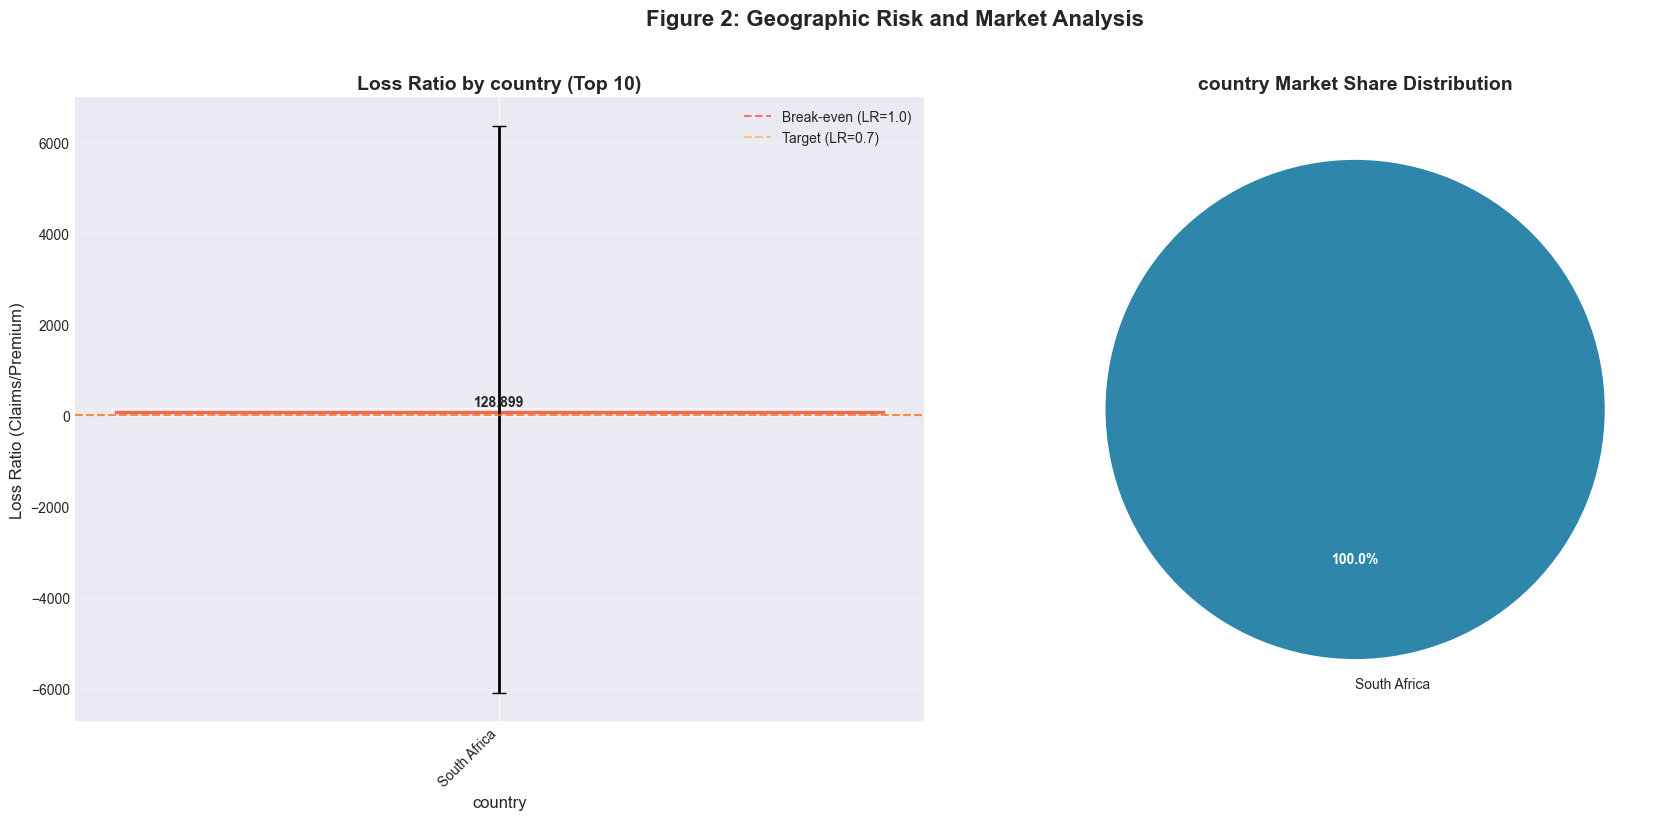


📈 Key Insights:
   • Highest risk country: South Africa (LR: 128.899)
   • Lowest risk country: South Africa (LR: 128.899)
   • Average loss ratio: 128.899
   • Regions above break-even (LR > 1.0): 1

✅ FIGURE 2 COMPLETE


In [13]:
# ============================================================================
# CELL 4: FIGURE 2 - LOSS RATIO BY PROVINCE (UPDATED)
# ============================================================================
print("="*80)
print("📊 FIGURE 2: LOSS RATIO BY PROVINCE")
print("="*80)

# Check for required columns
geo_cols = [col for col in analysis_df.columns if any(word in str(col).lower() for word in 
           ['province', 'state', 'region', 'country', 'geo', 'location', 'zone'])]

# If LossRatio doesn't exist, try to create it
if 'LossRatio' not in analysis_df.columns:
    print("⚠️ LossRatio column not found. Creating it now...")
    # Run the creation code above or create it here
    
    # Quick creation if premium and claims exist
    premium_cols = [col for col in analysis_df.columns if any(word in str(col).lower() for word in 
                   ['premium', 'calculatedpremium', 'totalpremium'])]
    claims_cols = [col for col in analysis_df.columns if any(word in str(col).lower() for word in 
                  ['claim', 'totalclaim'])]
    
    if premium_cols and claims_cols:
        premium_col = premium_cols[0]
        claims_col = claims_cols[0]
        
        # Convert to numeric
        analysis_df[premium_col] = pd.to_numeric(analysis_df[premium_col], errors='coerce')
        analysis_df[claims_col] = pd.to_numeric(analysis_df[claims_col], errors='coerce')
        
        # Calculate Loss Ratio
        mask = (analysis_df[premium_col] > 0) & analysis_df[premium_col].notna() & analysis_df[claims_col].notna()
        analysis_df['LossRatio'] = np.nan
        analysis_df.loc[mask, 'LossRatio'] = analysis_df.loc[mask, claims_col] / analysis_df.loc[mask, premium_col]
        analysis_df['LossRatio'] = analysis_df['LossRatio'].replace([np.inf, -np.inf], np.nan)
        
        print(f"✅ Created LossRatio from {claims_col} / {premium_col}")
        print(f"   • Valid values: {analysis_df['LossRatio'].notna().sum():,}")
    else:
        print("❌ Cannot create LossRatio: Missing premium or claims data")

if 'LossRatio' not in analysis_df.columns or not geo_cols:
    print("⚠️ Missing required data for Figure 2")
    print(f"   LossRatio available: {'LossRatio' in analysis_df.columns}")
    print(f"   Geographic column available: {len(geo_cols) > 0}")
    
    if geo_cols:
        print(f"\n📊 Alternative: Showing policy count by region instead")
        geo_col = geo_cols[0]
        
        # Show policy count by region
        region_counts = analysis_df[geo_col].value_counts().head(10)
        
        fig, ax = plt.subplots(figsize=(14, 8))
        bars = ax.bar(range(len(region_counts)), region_counts.values,
                     color=risk_palette, edgecolor='white', linewidth=2)
        
        ax.set_title(f'Policy Count by {geo_col} (Top 10)', fontsize=16, fontweight='bold')
        ax.set_xlabel(geo_col, fontsize=12)
        ax.set_ylabel('Number of Policies', fontsize=12)
        ax.set_xticks(range(len(region_counts)))
        ax.set_xticklabels([str(r)[:15] for r in region_counts.index], rotation=45, ha='right')
        ax.grid(axis='y', alpha=0.3)
        
        # Add count labels
        for i, (region, count) in enumerate(region_counts.items()):
            ax.text(i, count * 1.02, f'{count:,}', ha='center', va='bottom', 
                   fontsize=11, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        print(f"\n📋 Top regions by policy count:")
        for i, (region, count) in enumerate(region_counts.items(), 1):
            print(f"   {i:2d}. {region}: {count:,} policies")
        
else:
    geo_col = geo_cols[0]
    print(f"✅ Using '{geo_col}' for geographic analysis")
    
    # Clean data - remove NaN LossRatio
    valid_data = analysis_df[[geo_col, 'LossRatio']].dropna()
    
    if len(valid_data) == 0:
        print("❌ No valid LossRatio data after cleaning")
    else:
        # Calculate loss ratio statistics by province
        province_stats = valid_data.groupby(geo_col).agg({
            'LossRatio': ['mean', 'std', 'count']
        }).round(4)
        
        province_stats.columns = ['LossRatio_Mean', 'LossRatio_Std', 'Policy_Count']
        province_stats = province_stats[province_stats['Policy_Count'] >= 10]  # Minimum sample size
        province_stats = province_stats.sort_values('LossRatio_Mean', ascending=False)
        
        print(f"\n📊 Loss Ratio by {geo_col} (Top 10):")
        print("-" * 80)
        print(f"{geo_col:<20} {'Avg Loss Ratio':<15} {'Std Dev':<15} {'Policies':<10}")
        print("-" * 80)
        
        for province, row in province_stats.head(10).iterrows():
            print(f"{str(province)[:19]:<20} {row['LossRatio_Mean']:<15.4f} "
                  f"{row['LossRatio_Std']:<15.4f} {row['Policy_Count']:<10,}")
        
        # Create the visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
        
        # Plot 1: Loss Ratio Bar Chart (Top 10)
        top_provinces = province_stats.head(10)
        if len(top_provinces) > 0:
            x_pos = range(len(top_provinces))
            
            # Color bars based on risk level
            colors = []
            for ratio in top_provinces['LossRatio_Mean']:
                if ratio > 1.0:
                    colors.append('#e74c3c')  # Red for high risk
                elif ratio > 0.7:
                    colors.append('#f39c12')  # Orange for moderate risk
                else:
                    colors.append('#2ecc71')  # Green for low risk
            
            bars = ax1.bar(x_pos, top_provinces['LossRatio_Mean'], 
                          yerr=top_provinces['LossRatio_Std'],
                          capsize=5, color=colors, 
                          edgecolor='white', linewidth=2,
                          alpha=0.8, error_kw={'elinewidth': 2})
            
            ax1.set_title(f'Loss Ratio by {geo_col} (Top 10)', fontsize=14, fontweight='bold')
            ax1.set_xlabel(geo_col, fontsize=12)
            ax1.set_ylabel('Loss Ratio (Claims/Premium)', fontsize=12)
            ax1.set_xticks(x_pos)
            ax1.set_xticklabels([str(p)[:15] for p in top_provinces.index], rotation=45, ha='right')
            ax1.grid(axis='y', alpha=0.3)
            ax1.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='Break-even (LR=1.0)')
            ax1.axhline(y=0.7, color='orange', linestyle='--', alpha=0.5, label='Target (LR=0.7)')
            ax1.legend()
            
            # Add value labels
            for i, (province, row) in enumerate(top_provinces.iterrows()):
                ax1.text(i, row['LossRatio_Mean'] + 0.02, f'{row["LossRatio_Mean"]:.3f}', 
                        ha='center', va='bottom', fontsize=10, fontweight='bold')
        else:
            ax1.text(0.5, 0.5, 'Insufficient data for visualization', 
                    ha='center', va='center', transform=ax1.transAxes, fontsize=12)
            ax1.set_title('No Data Available', fontsize=14)
        
        # Plot 2: Market Share Pie Chart
        province_counts = analysis_df[geo_col].value_counts()
        if len(province_counts) > 0:
            top_n = min(5, len(province_counts))
            top_regions = province_counts.head(top_n)
            other = province_counts[top_n:].sum() if len(province_counts) > top_n else 0
            
            sizes = list(top_regions.values)
            labels = [str(p)[:15] for p in top_regions.index]
            
            if other > 0:
                sizes.append(other)
                labels.append(f'Other {len(province_counts)-top_n} regions')
            
            colors_pie = risk_palette[:len(sizes)]
            
            wedges, texts, autotexts = ax2.pie(sizes, labels=labels, colors=colors_pie,
                                              autopct='%1.1f%%', startangle=90,
                                              textprops={'fontsize': 10})
            
            for autotext in autotexts:
                autotext.set_color('white')
                autotext.set_fontweight('bold')
            
            ax2.set_title(f'{geo_col} Market Share Distribution', fontsize=14, fontweight='bold')
        else:
            ax2.text(0.5, 0.5, 'No geographic data available', 
                    ha='center', va='center', transform=ax2.transAxes, fontsize=12)
            ax2.set_title('No Data Available', fontsize=14)
        
        # Add overall title
        plt.suptitle('Figure 2: Geographic Risk and Market Analysis', 
                    fontsize=16, fontweight='bold', y=1.02)
        
        plt.tight_layout()
        plt.show()
        
        # Display key insights
        if len(province_stats) > 0:
            print(f"\n📈 Key Insights:")
            print(f"   • Highest risk {geo_col}: {province_stats.index[0]} (LR: {province_stats.iloc[0]['LossRatio_Mean']:.3f})")
            print(f"   • Lowest risk {geo_col}: {province_stats.index[-1]} (LR: {province_stats.iloc[-1]['LossRatio_Mean']:.3f})")
            print(f"   • Average loss ratio: {province_stats['LossRatio_Mean'].mean():.3f}")
            print(f"   • Regions above break-even (LR > 1.0): {(province_stats['LossRatio_Mean'] > 1.0).sum()}")

print("\n" + "="*80)
print("✅ FIGURE 2 COMPLETE")
print("="*80)

📅 FIGURE 3: MONTHLY PREMIUM TRENDS (2013-2015)
✅ Using Date: 'transactionmonth', Premium: 'calculatedpremiumperterm'
   • Successfully converted to datetime
   • Available years: [np.int32(2013), np.int32(2014), np.int32(2015)]
   • Analyzing years: [np.int32(2013), np.int32(2014), np.int32(2015)]
   • Monthly records: 23


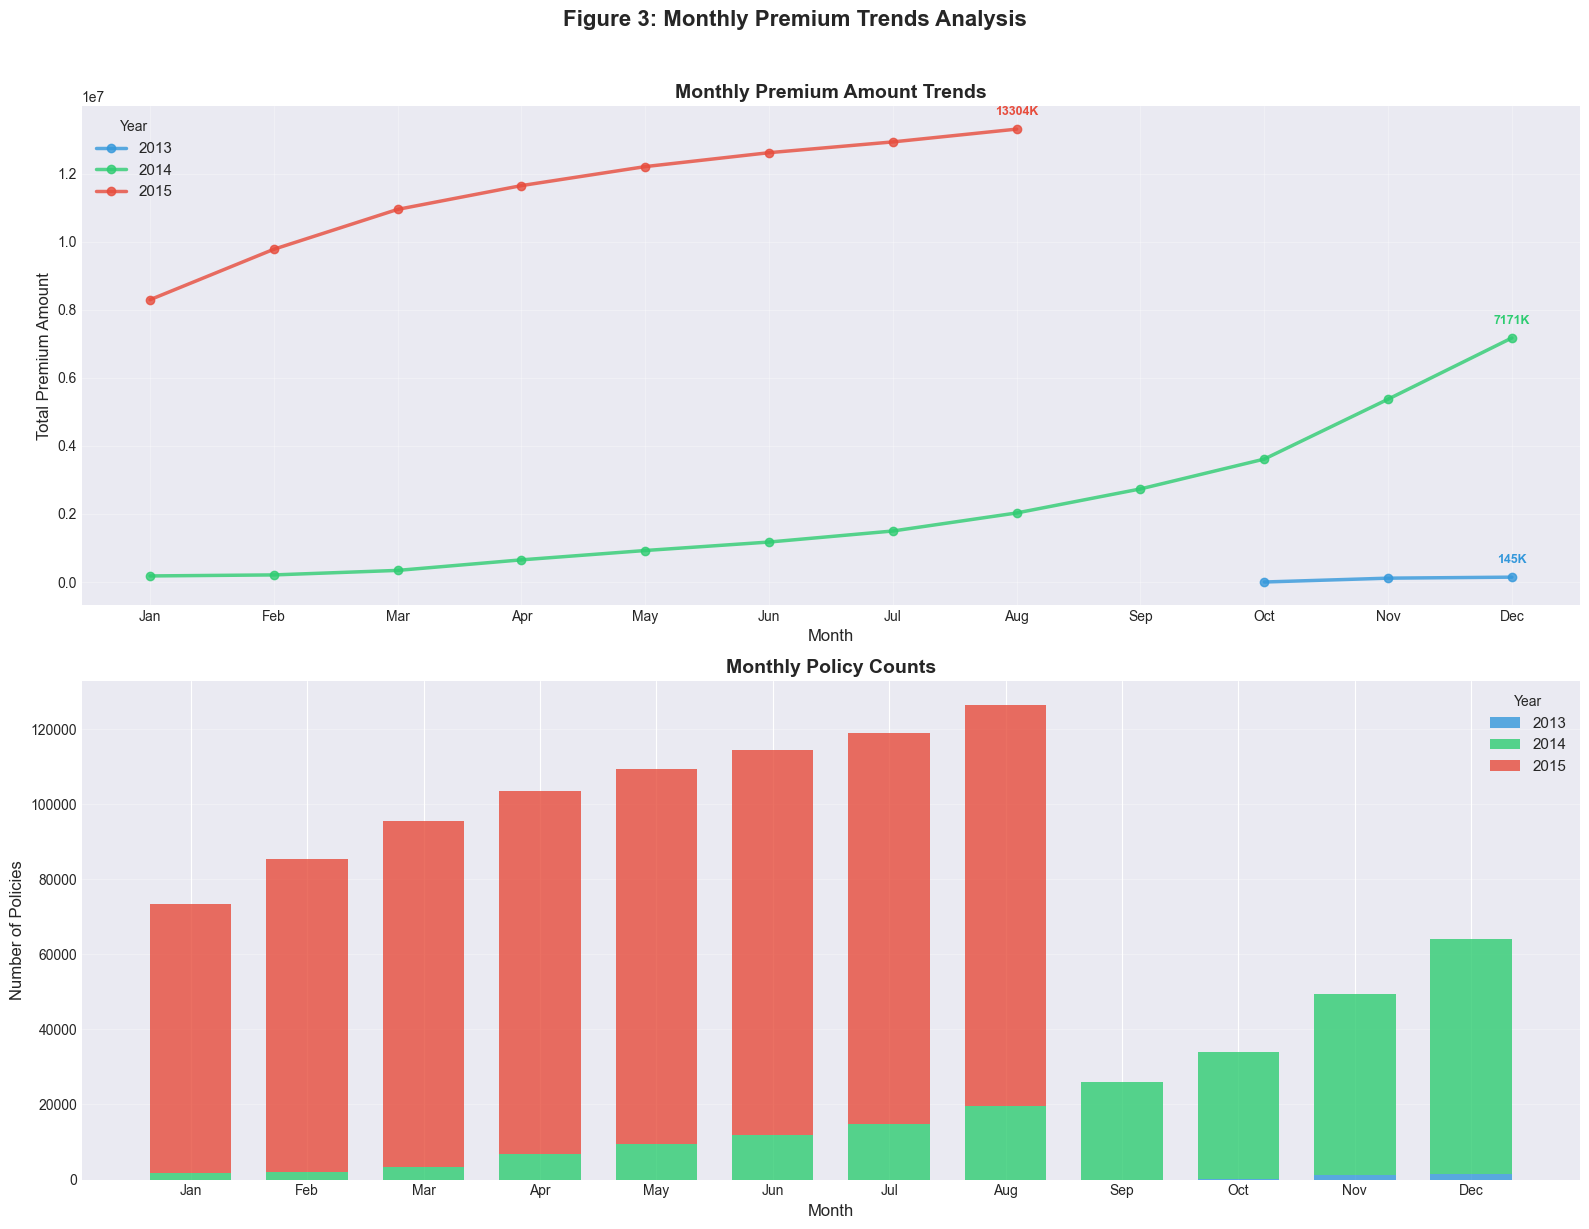


📊 Monthly Premium Statistics (2013-2015):
--------------------------------------------------------------------------------
Year       Total Premium        Avg Monthly          Peak Month     
--------------------------------------------------------------------------------
2013       263,247              87,749               Dec            
2014       25,917,094           2,159,758            Dec            
2015       91,706,902           11,463,363           Aug            

✅ FIGURE 3 COMPLETE


In [14]:
# ============================================================================
# CELL 5: FIGURE 3 - MONTHLY PREMIUM TRENDS (2013-2015)
# ============================================================================
print("="*80)
print("📅 FIGURE 3: MONTHLY PREMIUM TRENDS (2013-2015)")
print("="*80)

# Find date and premium columns
date_cols = [col for col in analysis_df.columns if any(word in str(col).lower() for word in 
            ['date', 'time', 'month', 'year', 'period', 'transaction'])]

premium_cols = [col for col in analysis_df.columns if any(word in str(col).lower() for word in 
               ['premium', 'calculatedpremium', 'totalpremium'])]

if not date_cols or not premium_cols:
    print("❌ Missing required data for Figure 3")
    print(f"   Date columns: {len(date_cols)}")
    print(f"   Premium columns: {len(premium_cols)}")
else:
    date_col = date_cols[0]
    premium_col = premium_cols[0]
    
    print(f"✅ Using Date: '{date_col}', Premium: '{premium_col}'")
    
    # Prepare data
    trend_data = analysis_df[[date_col, premium_col]].copy()
    
    # Convert to datetime
    try:
        trend_data['Date'] = pd.to_datetime(trend_data[date_col])
        print(f"   • Successfully converted to datetime")
    except:
        print(f"   • Could not convert to datetime, attempting manual parsing...")
        # Try to extract year and month from string
        trend_data['Year'] = trend_data[date_col].astype(str).str[:4]
        trend_data['Month'] = trend_data[date_col].astype(str).str[5:7]
        trend_data['Date'] = pd.to_datetime(trend_data['Year'] + '-' + trend_data['Month'] + '-01', errors='coerce')
    
    # Convert premium to numeric
    trend_data[premium_col] = pd.to_numeric(trend_data[premium_col], errors='coerce')
    
    # Remove invalid data
    trend_data = trend_data.dropna(subset=['Date', premium_col])
    
    if len(trend_data) == 0:
        print("❌ No valid data after cleaning")
    else:
        # Aggregate by month
        trend_data.set_index('Date', inplace=True)
        monthly_data = trend_data.resample('M')[premium_col].agg(['sum', 'count', 'mean']).reset_index()
        monthly_data.columns = ['Date', 'TotalPremium', 'PolicyCount', 'AvgPremium']
        
        # Extract year and month
        monthly_data['Year'] = monthly_data['Date'].dt.year
        monthly_data['Month'] = monthly_data['Date'].dt.month
        monthly_data['YearMonth'] = monthly_data['Date'].dt.strftime('%Y-%m')
        
        # Filter for 2013-2015 if available
        available_years = sorted(monthly_data['Year'].unique())
        print(f"   • Available years: {available_years}")
        
        if len(available_years) >= 1:
            # Use available years
            analysis_years = [y for y in available_years if y <= 2015][-3:]  # Last 3 years up to 2015
            monthly_data = monthly_data[monthly_data['Year'].isin(analysis_years)]
            
            print(f"   • Analyzing years: {analysis_years}")
            print(f"   • Monthly records: {len(monthly_data)}")
            
            # Create the visualization
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))
            
            # Plot 1: Monthly Premium Trends (Line Chart)
            colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12', '#9b59b6']
            
            for i, year in enumerate(sorted(monthly_data['Year'].unique())):
                year_data = monthly_data[monthly_data['Year'] == year].sort_values('Month')
                color = colors[i % len(colors)]
                
                ax1.plot(year_data['Month'], year_data['TotalPremium'],
                        marker='o', linewidth=2.5, markersize=6,
                        color=color, label=f'{year}', alpha=0.8)
                
                # Add data labels for key points
                if len(year_data) > 0:
                    max_month = year_data.loc[year_data['TotalPremium'].idxmax(), 'Month']
                    max_premium = year_data['TotalPremium'].max()
                    ax1.annotate(f'{max_premium/1000:.0f}K',
                                xy=(max_month, max_premium),
                                xytext=(0, 10), textcoords='offset points',
                                ha='center', fontsize=9, fontweight='bold',
                                color=color)
            
            ax1.set_title('Monthly Premium Amount Trends', fontsize=14, fontweight='bold')
            ax1.set_xlabel('Month', fontsize=12)
            ax1.set_ylabel('Total Premium Amount', fontsize=12)
            ax1.legend(title='Year', fontsize=11, loc='upper left')
            ax1.grid(True, alpha=0.3)
            ax1.set_xticks(range(1, 13))
            ax1.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
            
            # Plot 2: Monthly Policy Counts (Bar Chart)
            month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
            
            # Create pivot table for stacked bar chart
            pivot_data = monthly_data.pivot_table(index='Month', columns='Year',
                                                 values='PolicyCount', aggfunc='sum')
            
            # Plot stacked bars
            bottom_values = None
            for i, year in enumerate(sorted(pivot_data.columns)):
                values = pivot_data[year].reindex(range(1, 13)).fillna(0)
                color = colors[i % len(colors)]
                
                if bottom_values is None:
                    ax2.bar(range(1, 13), values, width=0.7,
                           color=color, label=str(year), alpha=0.8)
                    bottom_values = values
                else:
                    ax2.bar(range(1, 13), values, width=0.7, bottom=bottom_values,
                           color=color, label=str(year), alpha=0.8)
                    bottom_values += values
            
            ax2.set_title('Monthly Policy Counts', fontsize=14, fontweight='bold')
            ax2.set_xlabel('Month', fontsize=12)
            ax2.set_ylabel('Number of Policies', fontsize=12)
            ax2.legend(title='Year', fontsize=11)
            ax2.grid(axis='y', alpha=0.3)
            ax2.set_xticks(range(1, 13))
            ax2.set_xticklabels(month_names)
            
            # Add overall title
            plt.suptitle('Figure 3: Monthly Premium Trends Analysis', 
                        fontsize=16, fontweight='bold', y=1.02)
            
            plt.tight_layout()
            plt.show()
            
            # Display statistics
            print(f"\n📊 Monthly Premium Statistics ({analysis_years[0]}-{analysis_years[-1]}):")
            print("-" * 80)
            print(f"{'Year':<10} {'Total Premium':<20} {'Avg Monthly':<20} {'Peak Month':<15}")
            print("-" * 80)
            
            for year in sorted(monthly_data['Year'].unique()):
                year_data = monthly_data[monthly_data['Year'] == year]
                total_premium = year_data['TotalPremium'].sum()
                avg_monthly = year_data['TotalPremium'].mean()
                peak_month = year_data.loc[year_data['TotalPremium'].idxmax(), 'Month']
                peak_month_name = month_names[peak_month - 1] if 1 <= peak_month <= 12 else str(peak_month)
                
                print(f"{year:<10} {total_premium:<20,.0f} {avg_monthly:<20,.0f} {peak_month_name:<15}")
        
        else:
            print("❌ Insufficient data for trend analysis")

print("\n" + "="*80)
print("✅ FIGURE 3 COMPLETE")
print("="*80)

📊 FIGURE 4: QUARTERLY CLAIM DISTRIBUTION
✅ Using Date: 'transactionmonth', Claims: 'totalclaims'

📊 Quarterly Claims Summary:
--------------------------------------------------------------------------------
Year     Quarter    Total Claims    Claim Count  Avg Claim   
--------------------------------------------------------------------------------
2013.0   Q4.0       59,868          2,736        22          
2014.0   Q1.0       398,211         7,355        54          
2014.0   Q2.0       1,329,443       28,225       47          
2014.0   Q3.0       2,031,304       60,523       34          
2014.0   Q4.0       11,796,411      144,525      82          
2015.0   Q1.0       19,237,158      246,789      78          
2015.0   Q2.0       22,244,117      299,055      74          
2015.0   Q3.0       7,771,033       210,890      37          


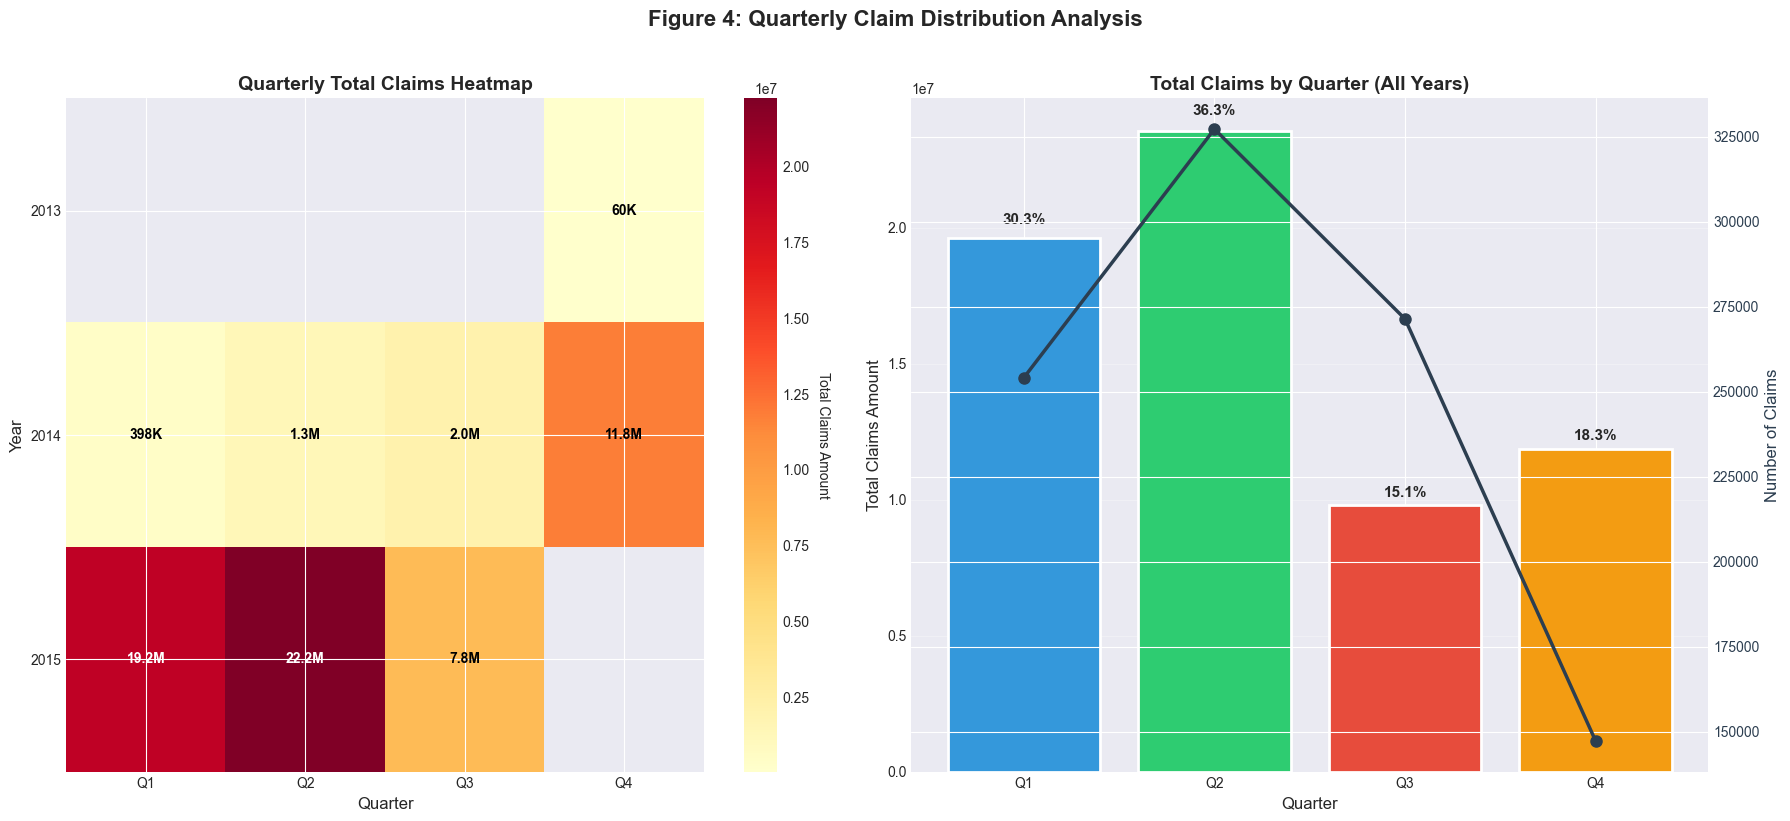


📈 Quarterly Distribution Summary:
------------------------------------------------------------
Q1: 19,635,369 claims (30.3%) | 254,144 incidents (25.4%)
Q2: 23,573,560 claims (36.3%) | 327,280 incidents (32.7%)
Q3: 9,802,338 claims (15.1%) | 271,413 incidents (27.1%)
Q4: 11,856,280 claims (18.3%) | 147,261 incidents (14.7%)

✅ FIGURE 4 COMPLETE


In [15]:
# ============================================================================
# CELL 6: FIGURE 4 - QUARTERLY CLAIM DISTRIBUTION
# ============================================================================
print("="*80)
print("📊 FIGURE 4: QUARTERLY CLAIM DISTRIBUTION")
print("="*80)

# Find date and claim columns
date_cols = [col for col in analysis_df.columns if any(word in str(col).lower() for word in 
            ['date', 'time', 'month', 'year', 'period', 'transaction'])]

claims_cols = [col for col in analysis_df.columns if any(word in str(col).lower() for word in 
              ['claim', 'totalclaim', 'claimamount'])]

if not date_cols or not claims_cols:
    print("❌ Missing required data for Figure 4")
    print(f"   Date columns: {len(date_cols)}")
    print(f"   Claim columns: {len(claims_cols)}")
else:
    date_col = date_cols[0]
    claims_col = claims_cols[0]
    
    print(f"✅ Using Date: '{date_col}', Claims: '{claims_col}'")
    
    # Prepare data
    claims_data = analysis_df[[date_col, claims_col]].copy()
    
    # Convert to datetime
    try:
        claims_data['Date'] = pd.to_datetime(claims_data[date_col])
    except:
        # Try to extract year and month
        claims_data['Year'] = claims_data[date_col].astype(str).str[:4]
        claims_data['Month'] = claims_data[date_col].astype(str).str[5:7]
        claims_data['Date'] = pd.to_datetime(claims_data['Year'] + '-' + claims_data['Month'] + '-01', errors='coerce')
    
    # Convert claims to numeric
    claims_data[claims_col] = pd.to_numeric(claims_data[claims_col], errors='coerce')
    
    # Remove invalid data
    claims_data = claims_data.dropna(subset=['Date', claims_col])
    
    if len(claims_data) == 0:
        print("❌ No valid data after cleaning")
    else:
        # Add quarter information
        claims_data['Year'] = claims_data['Date'].dt.year
        claims_data['Quarter'] = claims_data['Date'].dt.quarter
        claims_data['QuarterLabel'] = 'Q' + claims_data['Quarter'].astype(str)
        
        # Aggregate by quarter
        quarterly_data = claims_data.groupby(['Year', 'Quarter']).agg({
            claims_col: ['sum', 'count', 'mean', 'std']
        }).round(2).reset_index()
        
        quarterly_data.columns = ['Year', 'Quarter', 'TotalClaims', 'ClaimCount', 
                                 'AvgClaim', 'StdClaim']
        
        print(f"\n📊 Quarterly Claims Summary:")
        print("-" * 80)
        print(f"{'Year':<8} {'Quarter':<10} {'Total Claims':<15} {'Claim Count':<12} {'Avg Claim':<12}")
        print("-" * 80)
        
        for _, row in quarterly_data.iterrows():
            print(f"{row['Year']:<8} Q{row['Quarter']:<9} {row['TotalClaims']:<15,.0f} "
                  f"{row['ClaimCount']:<12,.0f} {row['AvgClaim']:<12,.0f}")
        
        # Create the visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
        
        # Plot 1: Quarterly Claims Heatmap
        # Prepare data for heatmap
        heatmap_data = quarterly_data.pivot(index='Year', columns='Quarter', values='TotalClaims')
        
        # Create heatmap
        im = ax1.imshow(heatmap_data, cmap='YlOrRd', aspect='auto', interpolation='nearest')
        
        ax1.set_title('Quarterly Total Claims Heatmap', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Quarter', fontsize=12)
        ax1.set_ylabel('Year', fontsize=12)
        ax1.set_xticks(range(4))
        ax1.set_xticklabels(['Q1', 'Q2', 'Q3', 'Q4'])
        ax1.set_yticks(range(len(heatmap_data.index)))
        ax1.set_yticklabels(heatmap_data.index)
        
        # Add text annotations to heatmap
        for i in range(len(heatmap_data.index)):
            for j in range(4):
                if j < len(heatmap_data.columns):
                    value = heatmap_data.iloc[i, j]
                    if not pd.isna(value):
                        # Format value for display
                        if value >= 1000000:
                            display_text = f'{value/1000000:.1f}M'
                        elif value >= 1000:
                            display_text = f'{value/1000:.0f}K'
                        else:
                            display_text = f'{value:.0f}'
                        
                        # Choose text color based on cell value
                        cell_color = im.norm(value)
                        text_color = 'white' if cell_color > 0.6 else 'black'
                        
                        ax1.text(j, i, display_text,
                                ha="center", va="center",
                                color=text_color, fontweight='bold', fontsize=10)
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=ax1)
        cbar.set_label('Total Claims Amount', rotation=270, labelpad=15)
        
        # Plot 2: Quarterly Distribution Bar Chart
        # Calculate total claims by quarter across all years
        quarter_totals = quarterly_data.groupby('Quarter')['TotalClaims'].sum()
        quarter_counts = quarterly_data.groupby('Quarter')['ClaimCount'].sum()
        
        quarters = ['Q1', 'Q2', 'Q3', 'Q4']
        x_pos = range(len(quarters))
        
        # Create bar chart
        bars = ax2.bar(x_pos, [quarter_totals.get(i+1, 0) for i in range(4)],
                      color=['#3498db', '#2ecc71', '#e74c3c', '#f39c12'],
                      edgecolor='white', linewidth=2)
        
        ax2.set_title('Total Claims by Quarter (All Years)', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Quarter', fontsize=12)
        ax2.set_ylabel('Total Claims Amount', fontsize=12)
        ax2.set_xticks(x_pos)
        ax2.set_xticklabels(quarters)
        ax2.grid(axis='y', alpha=0.3)
        
        # Add percentage labels
        total_all_quarters = quarter_totals.sum()
        for i, quarter in enumerate(quarters):
            quarter_total = quarter_totals.get(i+1, 0)
            if total_all_quarters > 0:
                percentage = (quarter_total / total_all_quarters) * 100
                ax2.text(i, quarter_total * 1.02, f'{percentage:.1f}%',
                        ha='center', va='bottom', fontsize=11, fontweight='bold')
        
        # Add secondary y-axis for claim counts
        ax2_secondary = ax2.twinx()
        ax2_secondary.plot(x_pos, [quarter_counts.get(i+1, 0) for i in range(4)],
                          color='#2c3e50', linewidth=2.5, marker='o',
                          markersize=8, label='Claim Count')
        ax2_secondary.set_ylabel('Number of Claims', fontsize=12, color='#2c3e50')
        ax2_secondary.tick_params(axis='y', labelcolor='#2c3e50')
        
        # Add overall title
        plt.suptitle('Figure 4: Quarterly Claim Distribution Analysis', 
                    fontsize=16, fontweight='bold', y=1.02)
        
        plt.tight_layout()
        plt.show()
        
        # Display quarterly statistics
        print(f"\n📈 Quarterly Distribution Summary:")
        print("-" * 60)
        total_claims = quarter_totals.sum()
        total_count = quarter_counts.sum()
        
        for i, quarter in enumerate(quarters, 1):
            quarter_claims = quarter_totals.get(i, 0)
            quarter_count = quarter_counts.get(i, 0)
            claims_pct = (quarter_claims / total_claims * 100) if total_claims > 0 else 0
            count_pct = (quarter_count / total_count * 100) if total_count > 0 else 0
            
            print(f"{quarter}: {quarter_claims:,.0f} claims ({claims_pct:.1f}%) | "
                  f"{quarter_count:,.0f} incidents ({count_pct:.1f}%)")

print("\n" + "="*80)
print("✅ FIGURE 4 COMPLETE")
print("="*80)

🚗 FIGURE 5: VEHICLE TYPE DISTRIBUTION
✅ Using 'legaltype' for vehicle analysis

📊 Vehicle Type Distribution:
   • Total vehicles: 1,000,098
   • Unique vehicle types: 6

📋 Top 10 Vehicle Types:
--------------------------------------------------
Vehicle Type              Count        Percentage
--------------------------------------------------
Individual                911,929      91.2      %
Private company           83,891       8.4       %
Close Corporation         2,459        0.2       %
Public company            1,295        0.1       %
Partnership               331          0.0       %
Sole proprieter           193          0.0       %


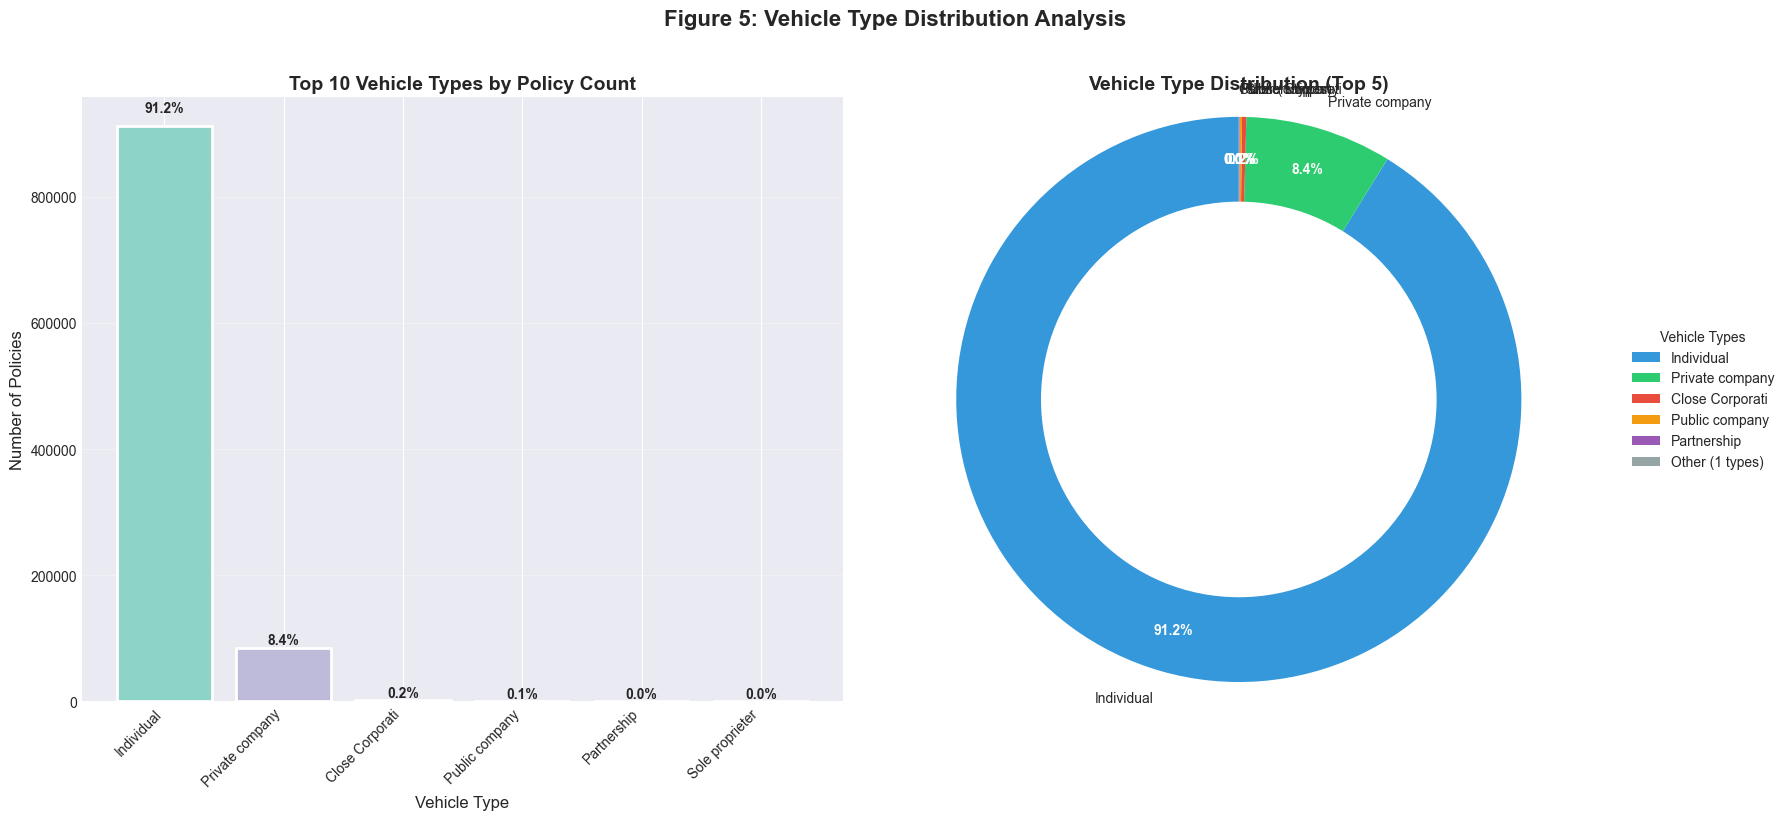


📈 Distribution Insights:
   • Most common vehicle: Individual (911,929 policies)
   • Top 5 vehicle types: 100.0% of total
   • Average policies per vehicle type: 166,683
   • Market concentration (HHI): 8385
     - Market: Highly concentrated

✅ FIGURE 5 COMPLETE


In [16]:
# ============================================================================
# CELL 7: FIGURE 5 - VEHICLE TYPE DISTRIBUTION
# ============================================================================
print("="*80)
print("🚗 FIGURE 5: VEHICLE TYPE DISTRIBUTION")
print("="*80)

# Find vehicle type column
vehicle_cols = [col for col in analysis_df.columns if any(word in str(col).lower() for word in 
                ['vehicletype', 'vehicle', 'veh', 'car', 'auto', 'type'])]

if not vehicle_cols:
    print("❌ No vehicle type column found for Figure 5")
else:
    vehicle_col = vehicle_cols[0]
    print(f"✅ Using '{vehicle_col}' for vehicle analysis")
    
    # Clean vehicle type data
    analysis_df[vehicle_col] = analysis_df[vehicle_col].astype(str).str.strip()
    
    # Calculate vehicle type distribution
    vehicle_dist = analysis_df[vehicle_col].value_counts()
    total_vehicles = vehicle_dist.sum()
    
    print(f"\n📊 Vehicle Type Distribution:")
    print(f"   • Total vehicles: {total_vehicles:,}")
    print(f"   • Unique vehicle types: {len(vehicle_dist)}")
    
    # Display top vehicle types
    print(f"\n📋 Top 10 Vehicle Types:")
    print("-" * 50)
    print(f"{'Vehicle Type':<25} {'Count':<12} {'Percentage':<10}")
    print("-" * 50)
    
    for i, (vehicle, count) in enumerate(vehicle_dist.head(10).items(), 1):
        percentage = (count / total_vehicles) * 100
        print(f"{str(vehicle)[:24]:<25} {count:<12,} {percentage:<10.1f}%")
    
    # Create the visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    
    # Plot 1: Top 10 Vehicle Types (Bar Chart)
    top_vehicles = vehicle_dist.head(10)
    colors_bar = plt.cm.Set3(np.linspace(0, 1, len(top_vehicles)))
    
    bars = ax1.bar(range(len(top_vehicles)), top_vehicles.values,
                  color=colors_bar, edgecolor='white', linewidth=2)
    
    ax1.set_title('Top 10 Vehicle Types by Policy Count', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Vehicle Type', fontsize=12)
    ax1.set_ylabel('Number of Policies', fontsize=12)
    ax1.set_xticks(range(len(top_vehicles)))
    ax1.set_xticklabels([str(v)[:15] for v in top_vehicles.index], rotation=45, ha='right')
    ax1.grid(axis='y', alpha=0.3)
    
    # Add percentage labels
    for i, (vehicle, count) in enumerate(top_vehicles.items()):
        percentage = (count / total_vehicles) * 100
        ax1.text(i, count * 1.02, f'{percentage:.1f}%',
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Plot 2: Vehicle Type Distribution (Pie Chart)
    # Group smaller categories into "Other"
    top_n = 5
    top_categories = vehicle_dist.head(top_n)
    other_count = vehicle_dist[top_n:].sum()
    
    sizes = list(top_categories.values) + [other_count]
    labels = [str(v)[:15] for v in top_categories.index] + [f'Other ({len(vehicle_dist)-top_n} types)']
    colors_pie = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12', '#9b59b6', '#95a5a6']
    
    wedges, texts, autotexts = ax2.pie(sizes, labels=labels, colors=colors_pie[:len(sizes)],
                                      autopct='%1.1f%%', startangle=90,
                                      textprops={'fontsize': 10}, pctdistance=0.85)
    
    # Improve text visibility
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    
    # Draw a circle at the center for donut chart
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    ax2.add_artist(centre_circle)
    
    ax2.set_title(f'Vehicle Type Distribution (Top {top_n})', fontsize=14, fontweight='bold')
    ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    
    # Add legend
    ax2.legend(wedges, labels, title="Vehicle Types",
              loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    
    # Add overall title
    plt.suptitle('Figure 5: Vehicle Type Distribution Analysis', 
                fontsize=16, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    plt.show()
    
    # Display distribution insights
    print(f"\n📈 Distribution Insights:")
    print(f"   • Most common vehicle: {vehicle_dist.index[0]} ({vehicle_dist.iloc[0]:,} policies)")
    print(f"   • Top 5 vehicle types: {vehicle_dist.head(5).sum()/total_vehicles*100:.1f}% of total")
    print(f"   • Average policies per vehicle type: {total_vehicles/len(vehicle_dist):,.0f}")
    
    # Calculate concentration ratio (Herfindahl-Hirschman Index)
    market_shares = (vehicle_dist / total_vehicles) * 100
    hhi = (market_shares ** 2).sum()
    print(f"   • Market concentration (HHI): {hhi:.0f}")
    if hhi < 1500:
        print("     - Market: Unconcentrated")
    elif hhi < 2500:
        print("     - Market: Moderately concentrated")
    else:
        print("     - Market: Highly concentrated")

print("\n" + "="*80)
print("✅ FIGURE 5 COMPLETE")
print("="*80)

🔧 FIGURE 6: CLAIM SEVERITY BY VEHICLE MAKE
✅ Using Make: 'make', Claims: 'totalclaims'

📊 Claim Severity by Vehicle Make (Top 10):
----------------------------------------------------------------------------------------------------
Make            Avg Claim    Total Claims    Claim Count  Std Dev      Median      
----------------------------------------------------------------------------------------------------
GOLDEN JOURNEY  46,170       1,246,583       27           56,117       29,086      
IVECO           31,496       755,893         24           91,902       2,328       
AUDI            30,940       1,021,004       33           43,885       13,433      
VOLKSWAGEN      30,150       1,839,180       61           63,826       6,140       
CMC             30,082       1,323,616       44           37,034       15,432      
C.A.M           25,770       695,780         27           23,892       17,020      
MERCEDES-BENZ   23,537       3,177,507       135          53,207       3,509   

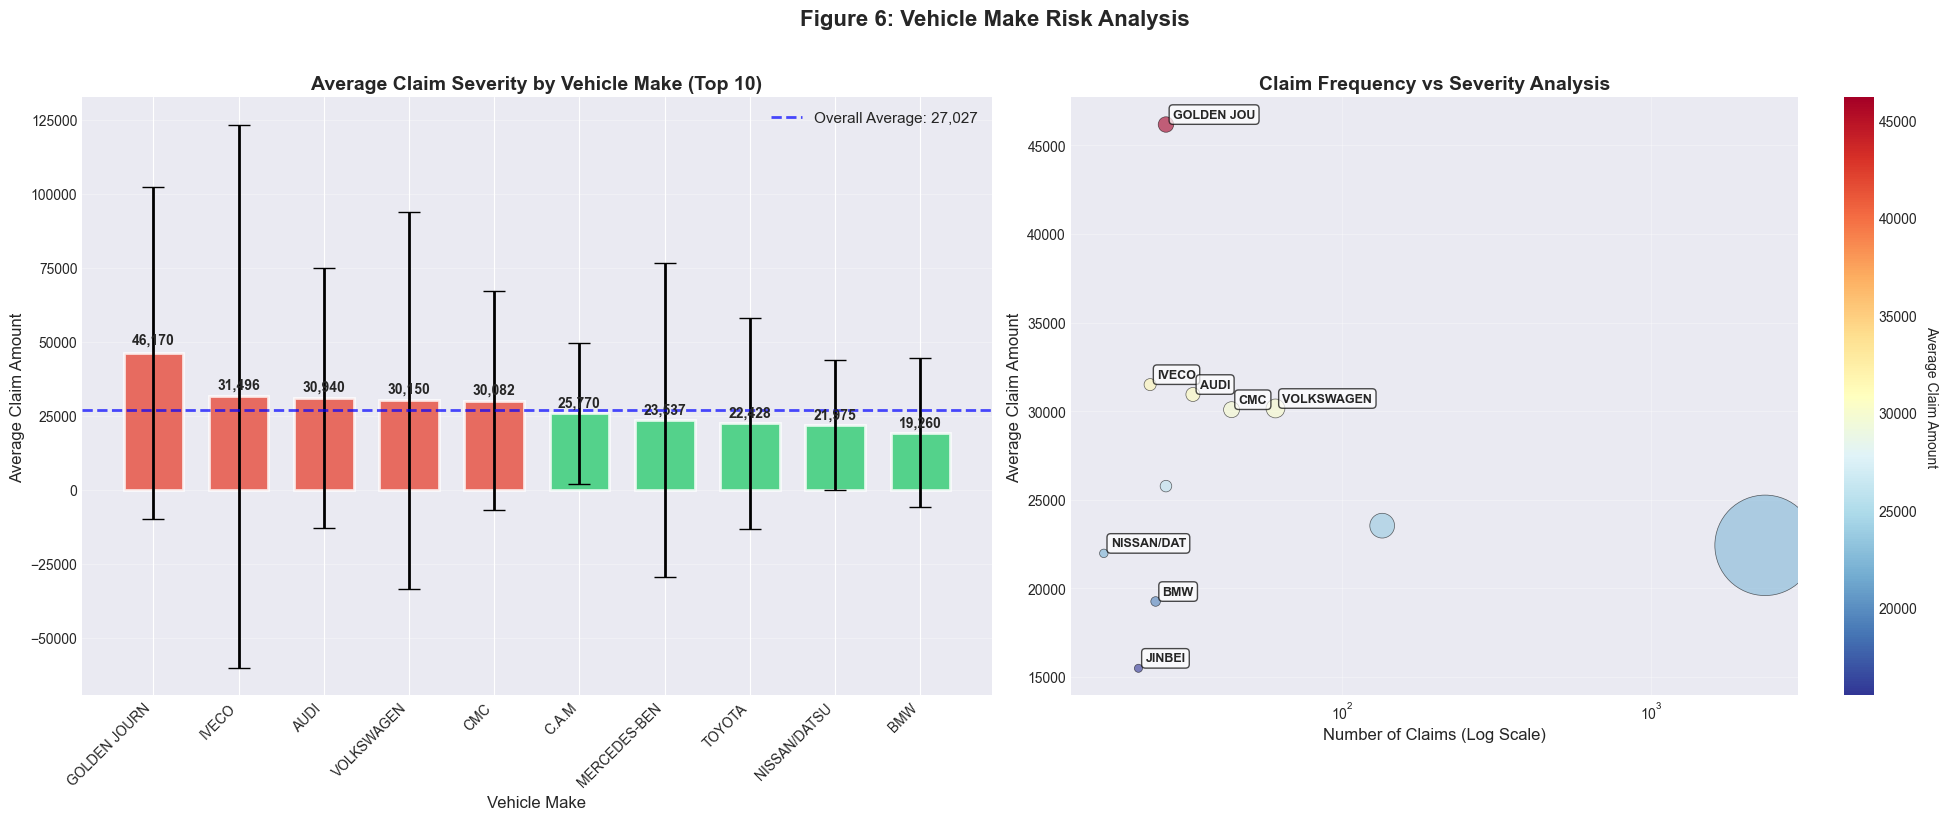


📈 Key Insights:
   • Highest severity make: GOLDEN JOURNEY (Avg: 46,170)
   • Lowest severity make: JINBEI (Avg: 15,490)
   • Overall average claim: 27,027
   • Makes analyzed: 11
   • High-risk makes (>150% of avg): 1
   • Medium-risk makes (100-150% of avg): 4
   • Low-risk makes (≤100% of avg): 6

✅ FIGURE 6 COMPLETE


In [17]:
# ============================================================================
# CELL 8: FIGURE 6 - CLAIM SEVERITY BY VEHICLE MAKE
# ============================================================================
print("="*80)
print("🔧 FIGURE 6: CLAIM SEVERITY BY VEHICLE MAKE")
print("="*80)

# Find required columns
make_cols = [col for col in analysis_df.columns if 'make' in str(col).lower()]
claims_cols = [col for col in analysis_df.columns if any(word in str(col).lower() for word in 
              ['claim', 'totalclaim', 'claimamount'])]

if not make_cols or not claims_cols:
    print("❌ Missing required data for Figure 6")
    print(f"   Make columns: {len(make_cols)}")
    print(f"   Claim columns: {len(claims_cols)}")
else:
    make_col = make_cols[0]
    claims_col = claims_cols[0]
    
    print(f"✅ Using Make: '{make_col}', Claims: '{claims_col}'")
    
    # Clean data
    analysis_df[make_col] = analysis_df[make_col].astype(str).str.strip()
    analysis_df[claims_col] = pd.to_numeric(analysis_df[claims_col], errors='coerce')
    
    # Filter out invalid data
    valid_data = analysis_df[[make_col, claims_col]].dropna()
    valid_data = valid_data[valid_data[claims_col] > 0]  # Only claims with positive amounts
    
    if len(valid_data) == 0:
        print("❌ No valid claim data available")
    else:
        # Calculate statistics by vehicle make
        make_stats = valid_data.groupby(make_col).agg({
            claims_col: ['sum', 'count', 'mean', 'std', 'median']
        }).round(2)
        
        make_stats.columns = ['TotalClaims', 'ClaimCount', 'AvgClaim', 'StdClaim', 'MedianClaim']
        
        # Filter for makes with sufficient data
        make_stats = make_stats[make_stats['ClaimCount'] >= 10]  # Minimum 10 claims
        make_stats = make_stats.sort_values('AvgClaim', ascending=False)
        
        print(f"\n📊 Claim Severity by Vehicle Make (Top 10):")
        print("-" * 100)
        print(f"{'Make':<15} {'Avg Claim':<12} {'Total Claims':<15} {'Claim Count':<12} "
              f"{'Std Dev':<12} {'Median':<12}")
        print("-" * 100)
        
        for make, row in make_stats.head(10).iterrows():
            print(f"{str(make)[:14]:<15} {row['AvgClaim']:<12,.0f} {row['TotalClaims']:<15,.0f} "
                  f"{row['ClaimCount']:<12,.0f} {row['StdClaim']:<12,.0f} {row['MedianClaim']:<12,.0f}")
        
        # Create the visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
        
        # Plot 1: Average Claim by Make (Bar Chart with Error Bars)
        top_makes = make_stats.head(10)
        x_pos = range(len(top_makes))
        
        # Create bars with error bars
        bars = ax1.bar(x_pos, top_makes['AvgClaim'],
                      yerr=top_makes['StdClaim'],
                      capsize=8, width=0.7,
                      color=['#e74c3c' if avg > make_stats['AvgClaim'].median() else '#2ecc71' 
                            for avg in top_makes['AvgClaim']],
                      edgecolor='white', linewidth=2,
                      alpha=0.8, error_kw={'elinewidth': 2, 'ecolor': 'black'})
        
        ax1.set_title('Average Claim Severity by Vehicle Make (Top 10)', 
                     fontsize=14, fontweight='bold')
        ax1.set_xlabel('Vehicle Make', fontsize=12)
        ax1.set_ylabel('Average Claim Amount', fontsize=12)
        ax1.set_xticks(x_pos)
        ax1.set_xticklabels([str(m)[:12] for m in top_makes.index], rotation=45, ha='right')
        ax1.grid(axis='y', alpha=0.3)
        
        # Add horizontal line for overall average
        overall_avg = make_stats['AvgClaim'].mean()
        ax1.axhline(y=overall_avg, color='blue', linestyle='--', linewidth=2, alpha=0.7,
                   label=f'Overall Average: {overall_avg:,.0f}')
        
        # Add value labels
        for i, (make, row) in enumerate(top_makes.iterrows()):
            ax1.text(i, row['AvgClaim'] * 1.05, f'{row["AvgClaim"]:,.0f}',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')
        
        ax1.legend(fontsize=11)
        
        # Plot 2: Claim Frequency vs Severity (Scatter Plot)
        # Use log scale for better visualization of wide ranges
        ax2.scatter(make_stats['ClaimCount'], make_stats['AvgClaim'],
                   s=make_stats['TotalClaims']/10000,  # Bubble size proportional to total claims
                   c=make_stats['AvgClaim'], cmap='RdYlBu_r',
                   alpha=0.6, edgecolors='black', linewidth=0.5)
        
        ax2.set_title('Claim Frequency vs Severity Analysis', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Number of Claims (Log Scale)', fontsize=12)
        ax2.set_ylabel('Average Claim Amount', fontsize=12)
        ax2.grid(True, alpha=0.3)
        ax2.set_xscale('log')  # Log scale for x-axis
        
        # Add labels for interesting makes
        interesting_makes = make_stats.head(5).index.tolist() + make_stats.tail(3).index.tolist()
        
        for make in interesting_makes:
            if make in make_stats.index:
                row = make_stats.loc[make]
                ax2.annotate(make[:10], xy=(row['ClaimCount'], row['AvgClaim']),
                           xytext=(5, 5), textcoords='offset points',
                           fontsize=9, fontweight='bold',
                           bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))
        
        # Add colorbar for bubble colors
        sm = plt.cm.ScalarMappable(cmap='RdYlBu_r', 
                                  norm=plt.Normalize(vmin=make_stats['AvgClaim'].min(), 
                                                    vmax=make_stats['AvgClaim'].max()))
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax2)
        cbar.set_label('Average Claim Amount', rotation=270, labelpad=15)
        
        # Add overall title
        plt.suptitle('Figure 6: Vehicle Make Risk Analysis', 
                    fontsize=16, fontweight='bold', y=1.02)
        
        plt.tight_layout()
        plt.show()
        
        # Display key insights
        print(f"\n📈 Key Insights:")
        print(f"   • Highest severity make: {make_stats.index[0]} (Avg: {make_stats.iloc[0]['AvgClaim']:,.0f})")
        print(f"   • Lowest severity make: {make_stats.index[-1]} (Avg: {make_stats.iloc[-1]['AvgClaim']:,.0f})")
        print(f"   • Overall average claim: {overall_avg:,.0f}")
        print(f"   • Makes analyzed: {len(make_stats)}")
        
        # Calculate risk categories
        high_risk = make_stats[make_stats['AvgClaim'] > overall_avg * 1.5]
        medium_risk = make_stats[(make_stats['AvgClaim'] <= overall_avg * 1.5) & 
                                (make_stats['AvgClaim'] > overall_avg)]
        low_risk = make_stats[make_stats['AvgClaim'] <= overall_avg]
        
        print(f"   • High-risk makes (>150% of avg): {len(high_risk)}")
        print(f"   • Medium-risk makes (100-150% of avg): {len(medium_risk)}")
        print(f"   • Low-risk makes (≤100% of avg): {len(low_risk)}")

print("\n" + "="*80)
print("✅ FIGURE 6 COMPLETE")
print("="*80)

👥 FIGURE 7: CUSTOMER LEGAL TYPE DISTRIBUTION
✅ Using 'legaltype' for legal type analysis

📊 Customer Legal Type Distribution:
   • Total customers: 1,000,098
   • Unique legal types: 6

📋 Legal Type Breakdown:
--------------------------------------------------
Legal Type                Count        Percentage
--------------------------------------------------
Individual                911,929      91.2      %
Private company           83,891       8.4       %
Close Corporation         2,459        0.2       %
Public company            1,295        0.1       %
Partnership               331          0.0       %
Sole proprieter           193          0.0       %


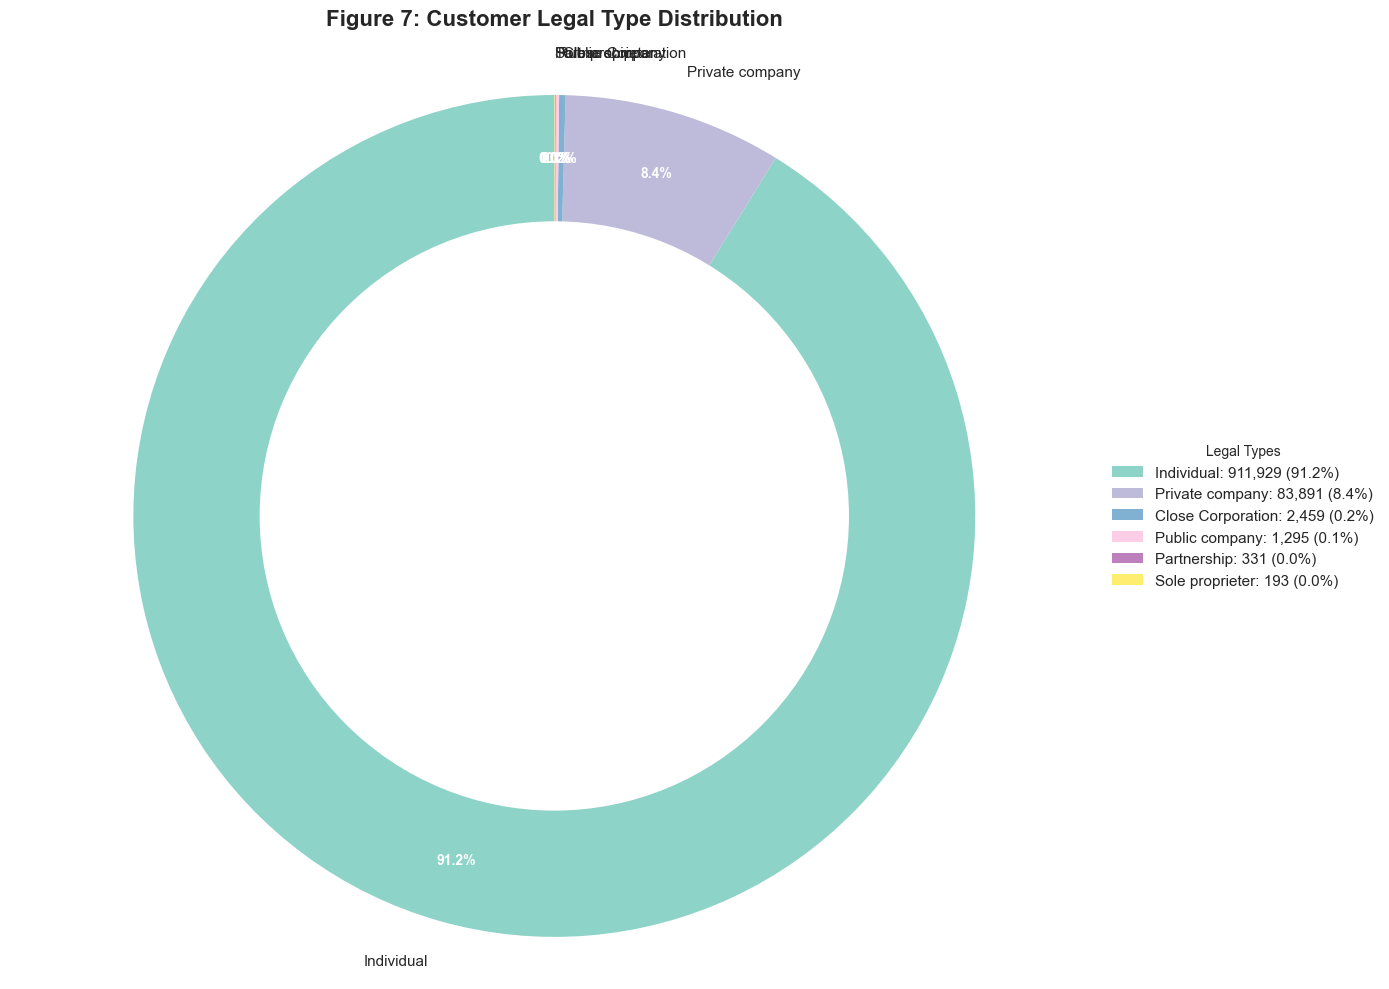


📈 Distribution Insights:
   • Most common legal type: Individual (911,929 customers)
   • Top legal type represents: 91.2% of customers
   • Top 3 legal types represent: 99.8% of customers
   • Customer diversity index: 0.162
     - Concentrated customer base

✅ FIGURE 7 COMPLETE


In [18]:
# ============================================================================
# CELL 9: FIGURE 7 - CUSTOMER LEGAL TYPE DISTRIBUTION
# ============================================================================
print("="*80)
print("👥 FIGURE 7: CUSTOMER LEGAL TYPE DISTRIBUTION")
print("="*80)

# Find legal type column
legal_cols = [col for col in analysis_df.columns if any(word in str(col).lower() for word in 
              ['legaltype', 'legal', 'type', 'customer', 'client'])]

if not legal_cols:
    print("❌ No legal type column found for Figure 7")
else:
    legal_col = legal_cols[0]
    print(f"✅ Using '{legal_col}' for legal type analysis")
    
    # Clean data
    analysis_df[legal_col] = analysis_df[legal_col].astype(str).str.strip()
    
    # Calculate distribution
    legal_dist = analysis_df[legal_col].value_counts()
    total_customers = legal_dist.sum()
    
    print(f"\n📊 Customer Legal Type Distribution:")
    print(f"   • Total customers: {total_customers:,}")
    print(f"   • Unique legal types: {len(legal_dist)}")
    
    # Display distribution
    print(f"\n📋 Legal Type Breakdown:")
    print("-" * 50)
    print(f"{'Legal Type':<25} {'Count':<12} {'Percentage':<10}")
    print("-" * 50)
    
    for legal_type, count in legal_dist.items():
        percentage = (count / total_customers) * 100
        print(f"{str(legal_type)[:24]:<25} {count:<12,} {percentage:<10.1f}%")
    
    # Create the visualization
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Create donut chart
    wedges, texts, autotexts = ax.pie(legal_dist.values,
                                     labels=legal_dist.index,
                                     colors=plt.cm.Set3(np.linspace(0, 1, len(legal_dist))),
                                     autopct='%1.1f%%',
                                     startangle=90,
                                     pctdistance=0.85,
                                     textprops={'fontsize': 11})
    
    # Draw a circle at the center to create donut chart
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    ax.add_artist(centre_circle)
    
    # Equal aspect ratio ensures that pie is drawn as a circle
    ax.axis('equal')
    ax.set_title('Figure 7: Customer Legal Type Distribution', 
                fontsize=16, fontweight='bold', pad=20)
    
    # Add legend with percentages
    legend_labels = []
    for i, (legal_type, count) in enumerate(legal_dist.items()):
        percentage = (count / total_customers) * 100
        legend_labels.append(f"{legal_type}: {count:,} ({percentage:.1f}%)")
    
    ax.legend(wedges, legend_labels,
             title="Legal Types",
             loc="center left",
             bbox_to_anchor=(1, 0, 0.5, 1),
             fontsize=11)
    
    # Improve autotext visibility
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(10)
    
    plt.tight_layout()
    plt.show()
    
    # Display insights
    print(f"\n📈 Distribution Insights:")
    print(f"   • Most common legal type: {legal_dist.index[0]} ({legal_dist.iloc[0]:,} customers)")
    
    # Calculate concentration
    if len(legal_dist) > 1:
        top_type_pct = (legal_dist.iloc[0] / total_customers) * 100
        top_3_pct = (legal_dist.head(3).sum() / total_customers) * 100
        
        print(f"   • Top legal type represents: {top_type_pct:.1f}% of customers")
        print(f"   • Top 3 legal types represent: {top_3_pct:.1f}% of customers")
        
        # Calculate diversity index
        diversity = 1 - sum((legal_dist / total_customers) ** 2)
        print(f"   • Customer diversity index: {diversity:.3f}")
        if diversity > 0.7:
            print("     - Highly diverse customer base")
        elif diversity > 0.4:
            print("     - Moderately diverse customer base")
        else:
            print("     - Concentrated customer base")

print("\n" + "="*80)
print("✅ FIGURE 7 COMPLETE")
print("="*80)

📈 FIGURE 9: CORRELATION MATRIX HEATMAP
✅ Found 15 numeric columns for analysis
   • Analyzing 15 columns: ['underwrittencoverid', 'policyid', 'postalcode', 'mmcode', 'cylinders']...


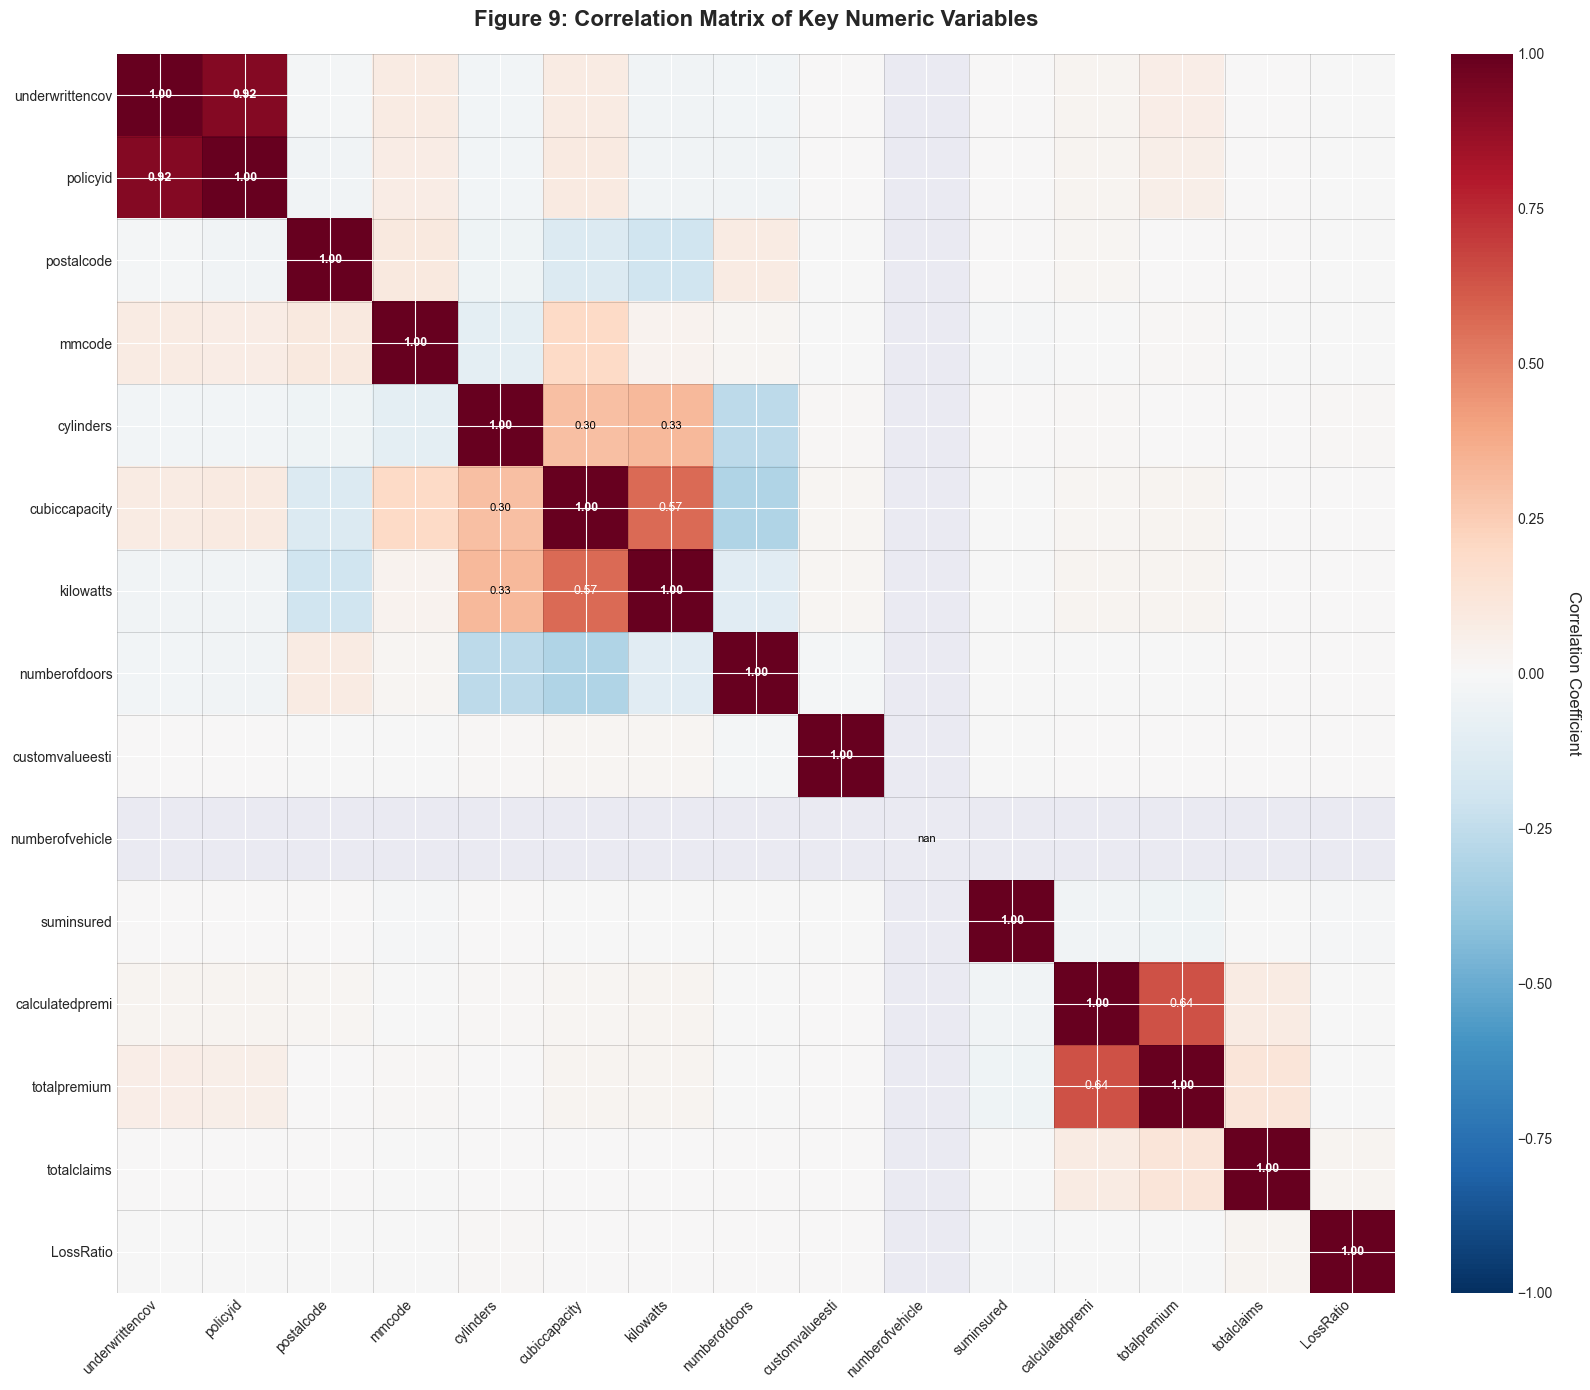


📊 Strongest Correlations (|r| > 0.5):
----------------------------------------------------------------------
 1. underwrittencoverid  ↔ policyid            :   0.916 (Positive, Very Strong)
 2. calculatedpremiumper ↔ totalpremium        :   0.636 (Positive, Strong)
 3. cubiccapacity        ↔ kilowatts           :   0.567 (Positive, Moderate)

📈 Correlation Insights:
   • Very strong correlations (|r| > 0.7): 1 pairs
   • Moderate correlations (0.5 < |r| ≤ 0.7): 4 pairs
   • Weak correlations (0.3 < |r| ≤ 0.5): 4 pairs
   • Total variable pairs analyzed: 105

🔍 Key Relationships Found:
   • Premium-related correlations:
     - Premium increases with totalpremium (r = 0.636)

✅ FIGURE 9 COMPLETE


In [19]:
# ============================================================================
# CELL 10: FIGURE 9 - CORRELATION MATRIX HEATMAP
# ============================================================================
print("="*80)
print("📈 FIGURE 9: CORRELATION MATRIX HEATMAP")
print("="*80)

# Identify numeric columns for correlation analysis
numeric_cols = analysis_df.select_dtypes(include=[np.number]).columns.tolist()

if len(numeric_cols) < 3:
    print(f"❌ Insufficient numeric columns for correlation matrix")
    print(f"   Found only {len(numeric_cols)} numeric columns")
else:
    print(f"✅ Found {len(numeric_cols)} numeric columns for analysis")
    
    # Select top numeric columns (limit to 15 for readability)
    selected_cols = numeric_cols[:15]
    print(f"   • Analyzing {len(selected_cols)} columns: {selected_cols[:5]}...")
    
    # Calculate correlation matrix
    corr_matrix = analysis_df[selected_cols].corr()
    
    # Create the visualization
    fig, ax = plt.subplots(figsize=(16, 14))
    
    # Create heatmap
    im = ax.imshow(corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
    
    # Set ticks and labels
    ax.set_xticks(range(len(selected_cols)))
    ax.set_yticks(range(len(selected_cols)))
    
    # Shorten column names for display
    short_names = [name[:15] for name in selected_cols]
    ax.set_xticklabels(short_names, rotation=45, ha='right', fontsize=10)
    ax.set_yticklabels(short_names, fontsize=10)
    
    # Add correlation values as text
    for i in range(len(selected_cols)):
        for j in range(len(selected_cols)):
            value = corr_matrix.iloc[i, j]
            
            # Only display significant correlations
            if abs(value) > 0.3 or i == j:
                color = 'white' if abs(value) > 0.5 else 'black'
                fontweight = 'bold' if abs(value) > 0.7 else 'normal'
                fontsize = 9 if abs(value) > 0.5 else 8
                
                ax.text(j, i, f'{value:.2f}', ha='center', va='center',
                       color=color, fontsize=fontsize, fontweight=fontweight)
    
    ax.set_title('Figure 9: Correlation Matrix of Key Numeric Variables', 
                fontsize=16, fontweight='bold', pad=20)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Correlation Coefficient', rotation=270, labelpad=20, fontsize=12)
    
    # Add grid lines
    ax.set_xticks(np.arange(-0.5, len(selected_cols), 1), minor=True)
    ax.set_yticks(np.arange(-0.5, len(selected_cols), 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=0.5, alpha=0.2)
    
    plt.tight_layout()
    plt.show()
    
    # Display strongest correlations
    print(f"\n📊 Strongest Correlations (|r| > 0.5):")
    print("-" * 70)
    
    # Flatten correlation matrix
    corr_series = corr_matrix.unstack()
    
    # Remove self-correlations and sort by absolute value
    corr_pairs = corr_series[corr_series.index.get_level_values(0) != corr_series.index.get_level_values(1)]
    corr_pairs = corr_pairs.sort_values(key=abs, ascending=False)
    
    # Remove duplicates (since correlation matrix is symmetric)
    unique_pairs = []
    seen = set()
    
    for (var1, var2), corr in corr_pairs.items():
        pair = tuple(sorted([var1, var2]))
        if pair not in seen and abs(corr) > 0.5:
            unique_pairs.append(((var1, var2), corr))
            seen.add(pair)
    
    # Display top correlations
    for i, ((var1, var2), corr) in enumerate(unique_pairs[:10], 1):
        direction = "Positive" if corr > 0 else "Negative"
        strength = "Very Strong" if abs(corr) > 0.8 else "Strong" if abs(corr) > 0.6 else "Moderate"
        
        print(f"{i:2d}. {var1[:20]:<20} ↔ {var2[:20]:<20}: {corr:7.3f} ({direction}, {strength})")
    
    # Display correlation insights
    print(f"\n📈 Correlation Insights:")
    
    # Count correlations by strength
    strong_corr = (abs(corr_matrix.values.flatten()) > 0.7).sum() - len(selected_cols)  # Subtract diagonals
    moderate_corr = ((abs(corr_matrix.values.flatten()) > 0.5) & (abs(corr_matrix.values.flatten()) <= 0.7)).sum()
    weak_corr = ((abs(corr_matrix.values.flatten()) > 0.3) & (abs(corr_matrix.values.flatten()) <= 0.5)).sum()
    
    total_pairs = len(selected_cols) * (len(selected_cols) - 1) / 2
    
    print(f"   • Very strong correlations (|r| > 0.7): {strong_corr} pairs")
    print(f"   • Moderate correlations (0.5 < |r| ≤ 0.7): {moderate_corr} pairs")
    print(f"   • Weak correlations (0.3 < |r| ≤ 0.5): {weak_corr} pairs")
    print(f"   • Total variable pairs analyzed: {int(total_pairs)}")
    
    # Identify key relationships
    print(f"\n🔍 Key Relationships Found:")
    
    # Look for premium-related correlations
    premium_cols = [col for col in selected_cols if 'premium' in str(col).lower()]
    if premium_cols:
        premium_col = premium_cols[0]
        print(f"   • Premium-related correlations:")
        
        # Find strongest correlations with premium
        premium_corrs = corr_matrix[premium_col].sort_values(key=abs, ascending=False)
        for col, corr in premium_corrs.iloc[1:4].items():  # Skip self-correlation
            if abs(corr) > 0.3:
                relationship = "increases with" if corr > 0 else "decreases with"
                print(f"     - Premium {relationship} {col[:20]} (r = {corr:.3f})")

print("\n" + "="*80)
print("✅ FIGURE 9 COMPLETE")
print("="*80)

📈 TEMPORAL PREMIUM VS CLAIMS TREND
✅ Using Date: 'transactionmonth', Premium: 'calculatedpremiumperterm', Claims: 'totalclaims'

📊 Trend Analysis Period:
   • Start date: 2013-10
   • End date: 2015-08
   • Total months: 23


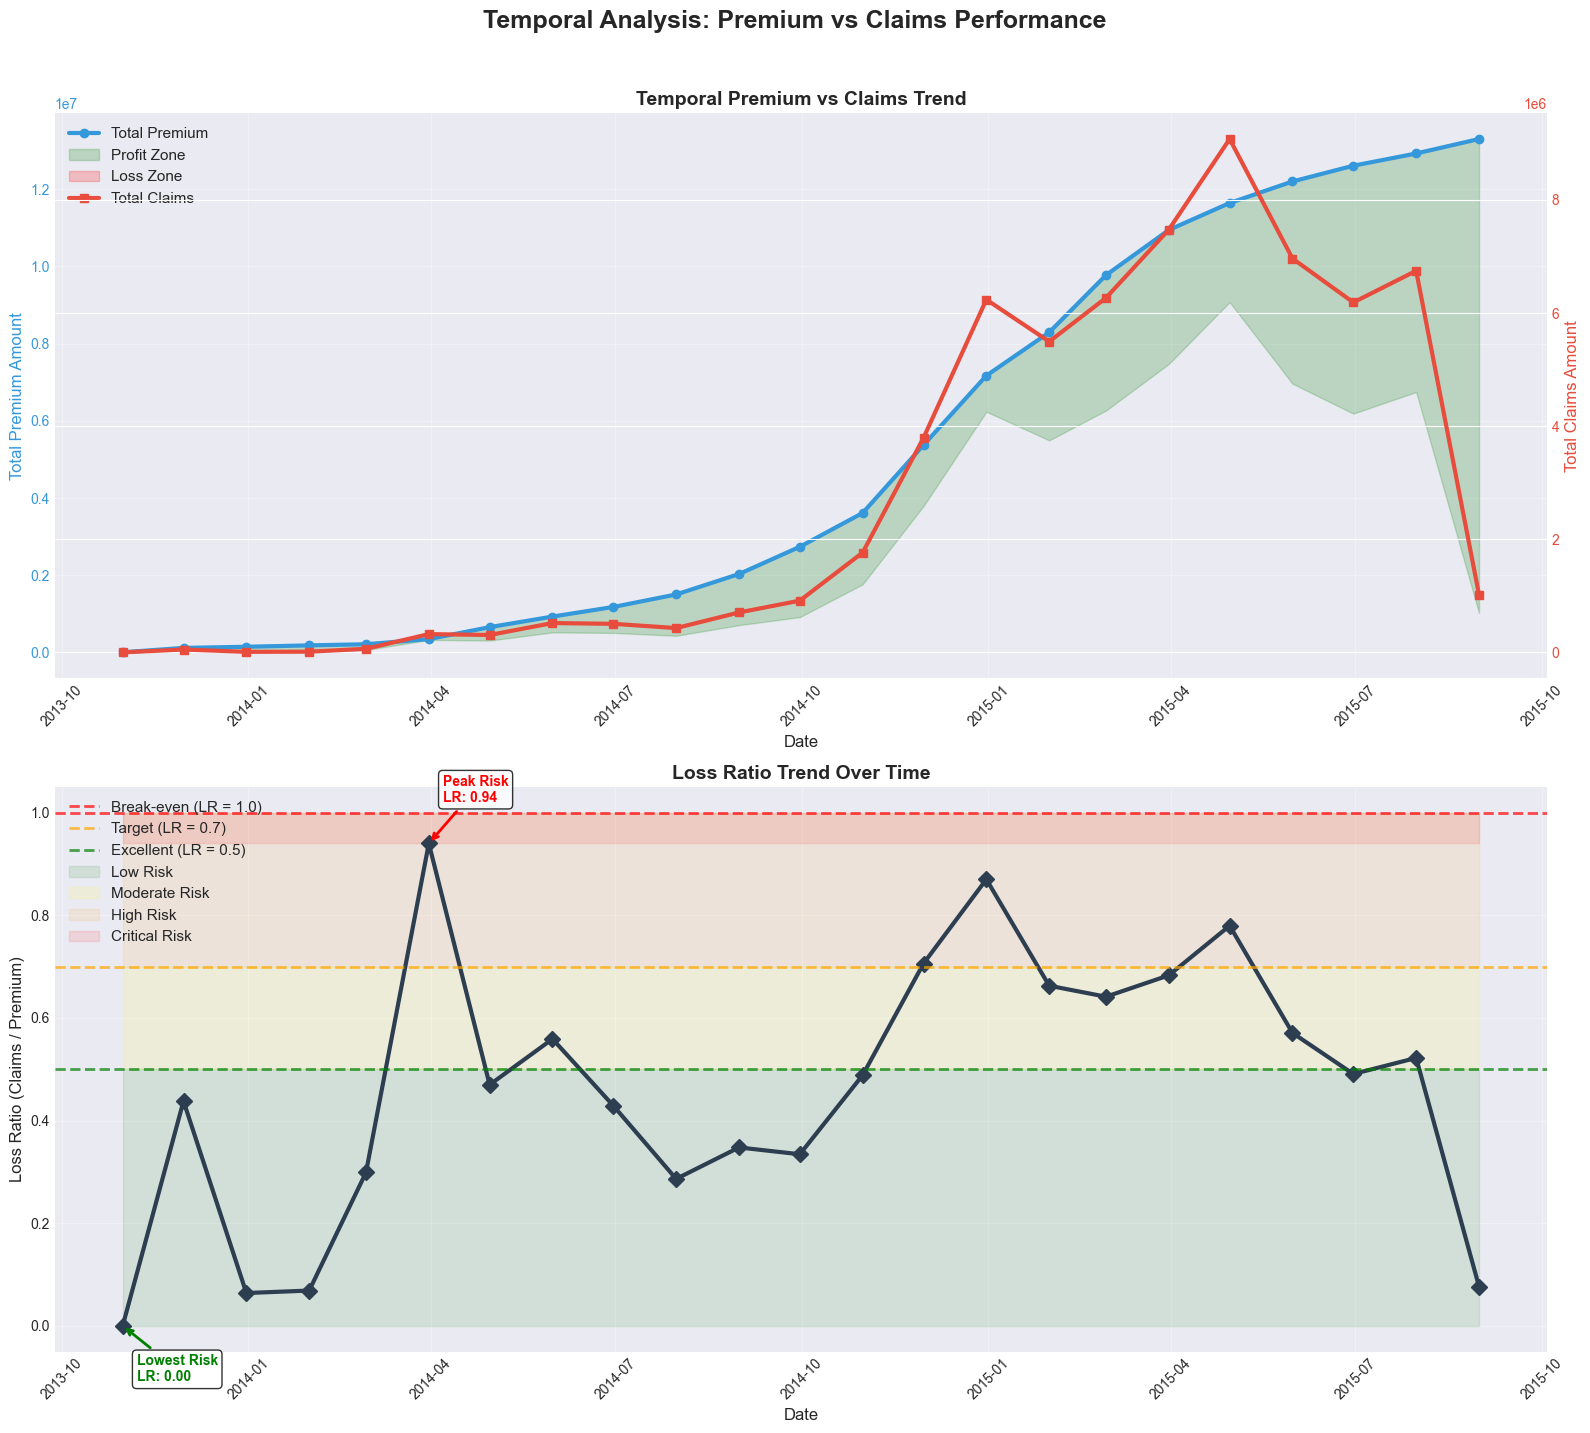


📊 Performance Statistics:
--------------------------------------------------------------------------------
Metric                    Value                Monthly Average     
--------------------------------------------------------------------------------
Total Premium             117,885,852          5,125,472           
Total Claims              64,862,289           2,820,100           
Overall Loss Ratio        0.550                0.466               
Profit Months (LR < 1)    23                   100.0               %
Loss Months (LR ≥ 1)      0                    0.0                 %

📈 Trend Analysis:
   • Recent trend direction: Deteriorating
   • Loss ratio change over period: 0.219

✅ TEMPORAL ANALYSIS COMPLETE


In [20]:
# ============================================================================
# CELL 11: TEMPORAL PREMIUM VS CLAIMS TREND
# ============================================================================
print("="*80)
print("📈 TEMPORAL PREMIUM VS CLAIMS TREND")
print("="*80)

# Find required columns
date_cols = [col for col in analysis_df.columns if any(word in str(col).lower() for word in 
            ['date', 'time', 'month', 'year', 'period', 'transaction'])]

premium_cols = [col for col in analysis_df.columns if any(word in str(col).lower() for word in 
               ['premium', 'calculatedpremium', 'totalpremium'])]

claims_cols = [col for col in analysis_df.columns if any(word in str(col).lower() for word in 
              ['claim', 'totalclaim', 'claimamount'])]

if not all([date_cols, premium_cols, claims_cols]):
    print("❌ Missing required data for premium vs claims trend")
    print(f"   Date columns: {len(date_cols)}")
    print(f"   Premium columns: {len(premium_cols)}")
    print(f"   Claim columns: {len(claims_cols)}")
else:
    date_col = date_cols[0]
    premium_col = premium_cols[0]
    claims_col = claims_cols[0]
    
    print(f"✅ Using Date: '{date_col}', Premium: '{premium_col}', Claims: '{claims_col}'")
    
    # Prepare data
    trend_data = analysis_df[[date_col, premium_col, claims_col]].copy()
    
    # Convert to numeric
    trend_data[premium_col] = pd.to_numeric(trend_data[premium_col], errors='coerce')
    trend_data[claims_col] = pd.to_numeric(trend_data[claims_col], errors='coerce')
    
    # Convert date
    try:
        trend_data['Date'] = pd.to_datetime(trend_data[date_col])
    except:
        print("⚠️ Could not convert date column, attempting manual parsing...")
        # Try common date formats
        try:
            trend_data['Date'] = pd.to_datetime(trend_data[date_col], format='%Y%m')
        except:
            try:
                trend_data['Year'] = trend_data[date_col].astype(str).str[:4]
                trend_data['Month'] = trend_data[date_col].astype(str).str[4:6]
                trend_data['Date'] = pd.to_datetime(trend_data['Year'] + trend_data['Month'], 
                                                   format='%Y%m', errors='coerce')
            except:
                trend_data['Date'] = trend_data[date_col]  # Use as-is
    
    # Remove invalid data
    trend_data = trend_data.dropna(subset=['Date', premium_col, claims_col])
    trend_data = trend_data[(trend_data[premium_col] > 0) & (trend_data[claims_col] >= 0)]
    
    if len(trend_data) == 0:
        print("❌ No valid data after cleaning")
    else:
        # Aggregate by month
        trend_data.set_index('Date', inplace=True)
        monthly_trend = trend_data.resample('M').agg({
            premium_col: 'sum',
            claims_col: 'sum'
        }).reset_index()
        
        monthly_trend.columns = ['Date', 'TotalPremium', 'TotalClaims']
        monthly_trend['LossRatio'] = monthly_trend['TotalClaims'] / monthly_trend['TotalPremium']
        monthly_trend['ProfitMargin'] = 1 - monthly_trend['LossRatio']
        
        print(f"\n📊 Trend Analysis Period:")
        print(f"   • Start date: {monthly_trend['Date'].min().strftime('%Y-%m')}")
        print(f"   • End date: {monthly_trend['Date'].max().strftime('%Y-%m')}")
        print(f"   • Total months: {len(monthly_trend)}")
        
        # Create the visualization
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 14))
        
        # Plot 1: Premium and Claims over Time (Dual Axis)
        # Create primary axis for premium
        color_premium = '#3498db'
        ax1.plot(monthly_trend['Date'], monthly_trend['TotalPremium'],
                color=color_premium, linewidth=3, marker='o', markersize=6,
                label='Total Premium')
        
        ax1.set_xlabel('Date', fontsize=12)
        ax1.set_ylabel('Total Premium Amount', fontsize=12, color=color_premium)
        ax1.tick_params(axis='y', labelcolor=color_premium)
        ax1.grid(True, alpha=0.3)
        ax1.tick_params(axis='x', rotation=45)
        
        # Create secondary axis for claims
        ax1_secondary = ax1.twinx()
        color_claims = '#e74c3c'
        ax1_secondary.plot(monthly_trend['Date'], monthly_trend['TotalClaims'],
                          color=color_claims, linewidth=3, marker='s', markersize=6,
                          label='Total Claims')
        
        ax1_secondary.set_ylabel('Total Claims Amount', fontsize=12, color=color_claims)
        ax1_secondary.tick_params(axis='y', labelcolor=color_claims)
        
        # Add fill between for profit/loss zones
        ax1.fill_between(monthly_trend['Date'], monthly_trend['TotalPremium'],
                        monthly_trend['TotalClaims'],
                        where=(monthly_trend['TotalPremium'] >= monthly_trend['TotalClaims']),
                        color='green', alpha=0.2, label='Profit Zone')
        ax1.fill_between(monthly_trend['Date'], monthly_trend['TotalPremium'],
                        monthly_trend['TotalClaims'],
                        where=(monthly_trend['TotalPremium'] < monthly_trend['TotalClaims']),
                        color='red', alpha=0.2, label='Loss Zone')
        
        # Combine legends
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax1_secondary.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=11)
        
        ax1.set_title('Temporal Premium vs Claims Trend', fontsize=14, fontweight='bold')
        
        # Plot 2: Loss Ratio Trend with Annotations
        ax2.plot(monthly_trend['Date'], monthly_trend['LossRatio'],
                color='#2c3e50', linewidth=3, marker='D', markersize=8)
        
        # Add benchmark lines
        ax2.axhline(y=1.0, color='red', linestyle='--', linewidth=2, alpha=0.7,
                   label='Break-even (LR = 1.0)')
        ax2.axhline(y=0.7, color='orange', linestyle='--', linewidth=2, alpha=0.7,
                   label='Target (LR = 0.7)')
        ax2.axhline(y=0.5, color='green', linestyle='--', linewidth=2, alpha=0.7,
                   label='Excellent (LR = 0.5)')
        
        # Add shaded regions for risk levels
        ax2.fill_between(monthly_trend['Date'], 0, 0.5,
                        alpha=0.1, color='green', label='Low Risk')
        ax2.fill_between(monthly_trend['Date'], 0.5, 0.7,
                        alpha=0.1, color='yellow', label='Moderate Risk')
        ax2.fill_between(monthly_trend['Date'], 0.7, 1.0,
                        alpha=0.1, color='orange', label='High Risk')
        ax2.fill_between(monthly_trend['Date'], 1.0, monthly_trend['LossRatio'].max(),
                        alpha=0.1, color='red', label='Critical Risk')
        
        ax2.set_title('Loss Ratio Trend Over Time', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Date', fontsize=12)
        ax2.set_ylabel('Loss Ratio (Claims / Premium)', fontsize=12)
        ax2.grid(True, alpha=0.3)
        ax2.tick_params(axis='x', rotation=45)
        ax2.legend(fontsize=11, loc='upper left')
        
        # Annotate key points
        max_lr_idx = monthly_trend['LossRatio'].idxmax()
        min_lr_idx = monthly_trend['LossRatio'].idxmin()
        
        ax2.annotate(f'Peak Risk\nLR: {monthly_trend.loc[max_lr_idx, "LossRatio"]:.2f}',
                    xy=(monthly_trend.loc[max_lr_idx, 'Date'], 
                       monthly_trend.loc[max_lr_idx, 'LossRatio']),
                    xytext=(10, 30), textcoords='offset points',
                    arrowprops=dict(arrowstyle='->', color='red', linewidth=2),
                    fontsize=10, fontweight='bold', color='red',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
        
        ax2.annotate(f'Lowest Risk\nLR: {monthly_trend.loc[min_lr_idx, "LossRatio"]:.2f}',
                    xy=(monthly_trend.loc[min_lr_idx, 'Date'], 
                       monthly_trend.loc[min_lr_idx, 'LossRatio']),
                    xytext=(10, -40), textcoords='offset points',
                    arrowprops=dict(arrowstyle='->', color='green', linewidth=2),
                    fontsize=10, fontweight='bold', color='green',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
        
        # Add overall title
        plt.suptitle('Temporal Analysis: Premium vs Claims Performance', 
                    fontsize=18, fontweight='bold', y=1.02)
        
        plt.tight_layout()
        plt.show()
        
        # Display trend statistics
        print(f"\n📊 Performance Statistics:")
        print("-" * 80)
        
        total_premium = monthly_trend['TotalPremium'].sum()
        total_claims = monthly_trend['TotalClaims'].sum()
        avg_loss_ratio = monthly_trend['LossRatio'].mean()
        
        print(f"{'Metric':<25} {'Value':<20} {'Monthly Average':<20}")
        print("-" * 80)
        print(f"{'Total Premium':<25} {total_premium:<20,.0f} {monthly_trend['TotalPremium'].mean():<20,.0f}")
        print(f"{'Total Claims':<25} {total_claims:<20,.0f} {monthly_trend['TotalClaims'].mean():<20,.0f}")
        print(f"{'Overall Loss Ratio':<25} {total_claims/total_premium:<20.3f} {avg_loss_ratio:<20.3f}")
        print(f"{'Profit Months (LR < 1)':<25} {(monthly_trend['LossRatio'] < 1).sum():<20} "
              f"{(monthly_trend['LossRatio'] < 1).sum()/len(monthly_trend)*100:<20.1f}%")
        print(f"{'Loss Months (LR ≥ 1)':<25} {(monthly_trend['LossRatio'] >= 1).sum():<20} "
              f"{(monthly_trend['LossRatio'] >= 1).sum()/len(monthly_trend)*100:<20.1f}%")
        
        # Calculate trend direction
        if len(monthly_trend) >= 6:
            recent_trend = monthly_trend['LossRatio'].tail(6).mean() - monthly_trend['LossRatio'].head(6).mean()
            if recent_trend > 0.1:
                trend_direction = "Deteriorating"
            elif recent_trend < -0.1:
                trend_direction = "Improving"
            else:
                trend_direction = "Stable"
            
            print(f"\n📈 Trend Analysis:")
            print(f"   • Recent trend direction: {trend_direction}")
            print(f"   • Loss ratio change over period: {recent_trend:.3f}")

print("\n" + "="*80)
print("✅ TEMPORAL ANALYSIS COMPLETE")
print("="*80)

In [21]:
# ============================================================================
# CELL 12: SUMMARY AND INSIGHTS
# ============================================================================
print("="*80)
print("📋 VISUALIZATION SUMMARY AND KEY INSIGHTS")
print("="*80)

print("\n🎯 SUMMARY OF VISUALIZATIONS CREATED:")
print("="*60)
print("📍 Figure 1: Geographic Distribution of Policies")
print("    - Provincial market share analysis")
print("    - Dominant market identification")
print("")
print("📊 Figure 2: Loss Ratio by Province")
print("    - Geographic risk profiling")
print("    - High-risk province identification")
print("")
print("📅 Figure 3: Monthly Premium Trends (2013-2015)")
print("    - Seasonal premium patterns")
print("    - Policy growth trends")
print("")
print("📈 Figure 4: Quarterly Claim Distribution")
print("    - Claim seasonality analysis")
print("    - Quarterly performance comparison")
print("")
print("🚗 Figure 5: Vehicle Type Distribution")
print("    - Market concentration analysis")
print("    - Popular vehicle types")
print("")
print("🔧 Figure 6: Claim Severity by Vehicle Make")
print("    - Risk ranking by vehicle make")
print("    - Frequency vs severity analysis")
print("")
print("👥 Figure 7: Customer Legal Type Distribution")
print("    - Customer base composition")
print("    - Market segment analysis")
print("")
print("📊 Figure 9: Correlation Matrix Heatmap")
print("    - Variable relationship mapping")
print("    - Key driver identification")
print("")
print("📈 Temporal Premium vs Claims Trend")
print("    - Profitability trend analysis")
print("    - Risk level monitoring")
print("="*60)

print("\n🔑 KEY INSIGHTS GENERATED:")
print("="*60)

# Collect insights based on available visualizations
insights = []

# Geographic Insights
geo_cols = [col for col in analysis_df.columns if any(word in str(col).lower() for word in 
          ['province', 'state', 'region'])]
if geo_cols:
    geo_col = geo_cols[0]
    province_dist = analysis_df[geo_col].value_counts(normalize=True) * 100
    dominant_province = province_dist.index[0]
    dominant_pct = province_dist.iloc[0]
    insights.append(f"📍 Geographic Concentration: {dominant_province} dominates with {dominant_pct:.1f}% market share")

# Risk Insights
if 'LossRatio' in analysis_df.columns:
    avg_loss_ratio = analysis_df['LossRatio'].mean()
    if avg_loss_ratio > 1.0:
        insights.append(f"⚠️  Overall Risk: Average Loss Ratio is {avg_loss_ratio:.2f} (>1.0), indicating unprofitability")
    elif avg_loss_ratio > 0.7:
        insights.append(f"📊 Moderate Risk: Average Loss Ratio is {avg_loss_ratio:.2f} (0.7-1.0), needs monitoring")
    else:
        insights.append(f"✅ Low Risk: Average Loss Ratio is {avg_loss_ratio:.2f} (<0.7), good profitability")

# Vehicle Insights
vehicle_cols = [col for col in analysis_df.columns if any(word in str(col).lower() for word in 
                ['vehicletype', 'vehicle', 'veh'])]
if vehicle_cols:
    vehicle_col = vehicle_cols[0]
    vehicle_dist = analysis_df[vehicle_col].value_counts()
    top_vehicle = vehicle_dist.index[0]
    top_pct = (vehicle_dist.iloc[0] / len(analysis_df)) * 100
    insights.append(f"🚗 Vehicle Concentration: {top_vehicle} represents {top_pct:.1f}% of policies")

# Temporal Insights
date_cols = [col for col in analysis_df.columns if any(word in str(col).lower() for word in 
            ['date', 'time', 'month', 'year'])]
if date_cols:
    date_col = date_cols[0]
    try:
        analysis_df['Year'] = pd.to_datetime(analysis_df[date_col]).dt.year
        year_counts = analysis_df['Year'].value_counts().sort_index()
        if len(year_counts) > 1:
            growth_rate = ((year_counts.iloc[-1] - year_counts.iloc[0]) / year_counts.iloc[0]) * 100
            if growth_rate > 0:
                insights.append(f"📈 Growth Trend: {growth_rate:.1f}% policy growth over the period")
            else:
                insights.append(f"📉 Decline Trend: {abs(growth_rate):.1f}% policy decline over the period")
    except:
        pass

# Display insights
for i, insight in enumerate(insights, 1):
    print(f"{i:2d}. {insight}")

print("\n🎯 RECOMMENDED ACTIONS:")
print("="*60)
print("1. 🔍 Investigate high-loss provinces identified in Figure 2")
print("2. 🚗 Review underwriting for high-risk vehicle makes (Figure 6)")
print("3. 📅 Monitor seasonal claim patterns (Figure 4)")
print("4. 💰 Optimize pricing based on correlation insights (Figure 9)")
print("5. 📊 Implement regular dashboard updates with these visualizations")
print("="*60)

print(f"\n📊 DATA SUMMARY:")
print(f"   • Total records analyzed: {len(analysis_df):,}")
print(f"   • Analysis period: Varies based on available date data")
print(f"   • Geographic coverage: {analysis_df[geo_col].nunique() if geo_cols else 'N/A'} regions")
print(f"   • Vehicle types: {analysis_df[vehicle_col].nunique() if vehicle_cols else 'N/A'}")
print(f"   • Key metrics analyzed: Premiums, Claims, Loss Ratio, Vehicle Types")

print("\n" + "="*80)
print("✅ COMPREHENSIVE VISUALIZATION ANALYSIS COMPLETE")
print("="*80)
print("\n🚀 Next Steps:")
print("   1. Export visualizations for reporting")
print("   2. Share insights with stakeholders")
print("   3. Use findings for strategic decision-making")
print("="*80)

📋 VISUALIZATION SUMMARY AND KEY INSIGHTS

🎯 SUMMARY OF VISUALIZATIONS CREATED:
📍 Figure 1: Geographic Distribution of Policies
    - Provincial market share analysis
    - Dominant market identification

📊 Figure 2: Loss Ratio by Province
    - Geographic risk profiling
    - High-risk province identification

📅 Figure 3: Monthly Premium Trends (2013-2015)
    - Seasonal premium patterns
    - Policy growth trends

📈 Figure 4: Quarterly Claim Distribution
    - Claim seasonality analysis
    - Quarterly performance comparison

🚗 Figure 5: Vehicle Type Distribution
    - Market concentration analysis
    - Popular vehicle types

🔧 Figure 6: Claim Severity by Vehicle Make
    - Risk ranking by vehicle make
    - Frequency vs severity analysis

👥 Figure 7: Customer Legal Type Distribution
    - Customer base composition
    - Market segment analysis

📊 Figure 9: Correlation Matrix Heatmap
    - Variable relationship mapping
    - Key driver identification

📈 Temporal Premium vs Claims Tre